In [1]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import itertools as it
import py4DSTEM
import glob
import sys
import os
from random import sample
from time import time
import collections
# from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from copy import deepcopy
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def flatten(list1):
    return [item for sublist in list1 for item in sublist]

def test_radial_representation(df, indicies, thicknesses, df_only_radial = None):
    if type(df_only_radial) == type(None):
        output_list = []
        for thickness in thicknesses:
            for index in indicies:
                print([index, df_copy.iloc[index]])
                pattern_scaled_use = np.zeros((41,13), dtype=np.complex128)
                basis, mask = calc_basis_scaled_df(df.iloc[index]['thickness_'+ thickness], 2, 0.05, 12)
                pattern_scaled = basis*df.iloc[index]['thickness_'+ thickness].data['intensity'][mask]

                for i in range(0, len(pattern_scaled)):
                    for j in range(0, len(pattern_scaled[0])):
                        pattern_scaled_use[i][j] = sum(pattern_scaled[i][j])


                test_passed = True
                for i in range(0, len(df_copy.iloc[index]['radial_' + thickness + '_Colin_basis'])):
                    for j in range(0, len(df_copy.iloc[index]['radial_' + thickness + '_Colin_basis'][0])):
                        assert(df_copy.iloc[index]['radial_' + thickness + '_Colin_basis'][i][j] == pattern_scaled_use[i][j])
                        if not df_copy.iloc[index]['radial_' + thickness + '_Colin_basis'][i][j] == pattern_scaled_use[i][j]:
                            test_passed = False

                if test_passed == False:
                    output_list.append([test_passed, thickness, index])
               
                print(thickness, index, test_passed)

        if len(output_list) == 0:
            return 'All tests passed'
        else:
            return output_list

    else: 
        output_list = []
        for thickness in thicknesses:
            for index in indicies:
                test_passed = True
                pattern_scaled_use = df_only_radial.iloc[index]['radial_'+ thickness + '_Colin_basis']


                for i in range(0, len(df_copy.iloc[index]['radial_' + thickness + '_Colin_basis'])):
                    for j in range(0, len(df_copy.iloc[index]['radial_' + thickness + '_Colin_basis'][0])):
                        assert(df_copy.iloc[index]['radial_' + thickness + '_Colin_basis'][i][j] == pattern_scaled_use[i][j])
                        if not df_copy.iloc[index]['radial_' + thickness + '_Colin_basis'][i][j] == pattern_scaled_use[i][j]:
                            test_passed = False

                if test_passed == False:
                    output_list.append([test_passed, thickness, index])
                
                print(thickness, index, test_passed)


        if len(output_list) == 0:
            return 'All tests passed'
        else:
            return output_list
        
def construct_basis(kx, ky, k_max, dk, order_max, sine_basis=False):
    """
    
    
    Placeholder
    
    """
    # k bin boundaries starts at zero extends to kmax
    k_bins = np.arange(0, k_max+dk, dk)
    
    # no elements, size of the basis, so 
    # radial_bins, 
    if kx.ndim == 1:
        basis_size = (k_bins.shape[0], order_max+1, kx.shape[0])
    elif kx.ndim > 1:
        basis_size = (k_bins.shape[0], order_max+1, *kx.shape)
    else:
        print('error')
        
    basis = np.zeros(basis_size, dtype=np.complex128)
    # print(basis.shape)
    kr = np.hypot(kx, ky)
    # ensure ky, kx (alex check why)
    phi = np.arctan2(ky,kx)
    
    # loop over the bins
    for ind, k in enumerate(k_bins):
        # calculate the basis functions
        # create the mask to select
        sub = np.logical_and(kr > k - dk,  kr < k + dk)
        
        b_radial = 1 - np.abs(kr[sub] - k) / dk
        if sine_basis:
            b_radial = np.sin(b_radial * (np.pi / 2) ) ** 2
        
        for ind_order, order in enumerate(range(order_max + 1)): 
#             b_annular =  np.cos(order * phi[sub]) + 1j * np.sin(order * phi[sub])
            
            b_annular = np.exp((1j * order) * phi[sub])
            
            basis[ind, ind_order][sub] = b_radial * b_annular
            
            
            
    return basis 


def calc_basis_scaled_df(bragg_list, k_max, dk, order_max, sine_basis=False, remove_central_beam = True):
    new_bragg_list = deepcopy(bragg_list) # create a copy # probably not needed

    if remove_central_beam:
        # print(new_pl.data.shape)
        # print(new_bragg_list[0])
        # print(new_bragg_list.data)
        # print(new_bragg_list.data['intensity'])
        mask = np.ones_like(new_bragg_list.data['intensity'], dtype=bool)
        index = np.where(new_bragg_list.data['intensity'] == np.max(new_bragg_list.data['intensity']))[0][0]
        mask[index] = False
        # new_bragg_list.data = new_bragg_list.data[mask] return to this when going back to 13.3
        new_bragg_list._data = new_bragg_list.data[mask]

        # print(new_pl.data.shape)
    
    basis = construct_basis(new_bragg_list.data['qx'], new_bragg_list.data['qy'], k_max, dk, order_max, sine_basis)
    
    if remove_central_beam:
        return [basis, mask] 
    else:
        return basis

def visualize_specific_pattern(point_lists, index, intensity_scaling = 0.3):
    pl = point_lists.cal[index[0],index[1]] # indvidual pointlist qx,qy,ints
    pl.data['intensity'] = pl.data['intensity']/(sum(pl.data['intensity'])/intensity_scaling)
    fig, ax = plot_diffraction_pattern(pl, returnfig = True)
    return fig
    
def clean_and_scale_pls(point_lists, sum_scaling = 0.3, num_spots_needed = 5, remove_central_beam = True):
    print('scaling patterns to sum intensity = '+str(sum_scaling)+' and filtering out patterns with fewer than ' 
          + str(num_spots_needed) + ' diffraction spots') 
    
    pl_indicies = []
    scaled_patterns = []
    for i in range(pls.shape[0]):
    # for i in range(4):
        print(i)
        for j in range(pls.shape[1]):
        # for j in range(4):
            # try:
            # print(i,j)
            pattern = pls.cal[i,j]
            if len(pattern.data['intensity']) >= num_spots_needed: 
                pattern.data['intensity'] = pattern.data['intensity']/(sum(pattern.data['intensity'])/sum_scaling)
                basis, mask = calc_basis_scaled_df(pattern, 2, 0.05, 12, remove_central_beam = remove_central_beam)
                pattern_scaled_use = np.zeros((41,13), dtype=np.complex128)
                pattern_scaled = basis*pattern.data['intensity'][mask]
                # pattern_scaled = basis*pattern.data['intensity']
                for x in range(0, len(pattern_scaled)):
                    for y in range(0, len(pattern_scaled[0])):
                        pattern_scaled_use[x][y] = sum(pattern_scaled[x][y])
                scaled_patterns.append(pattern_scaled_use)
                pl_indicies.append([i,j])
            else:
                pass
            # except:
                # pass
    
    print('finished scaling and filtering!')
    return scaled_patterns, pl_indicies


def add_confidences_to_pred_df(df_with_predictions, num_trees = 80):
    new_df_with_predictions = df_with_predictions.copy()
    
    
    predictions_diff_confidence = []
    predictions_std = []
    for i in range(0, len(df_with_predictions)):
        # print(i/len(df_with_predictions))
        row = df_with_predictions.iloc[i]
        full_pred = row.full_predictions
        # print(full_pred)
        pred_df_temp = pd.DataFrame(full_pred, columns=['Full_predictions'])
        # print(pred_df_temp)
        # print(pred_df_temp.Full_predictions)
        # print(pred_df_temp.Full_predictions.value_counts())
        vals = np.asarray(pred_df_temp.Full_predictions.value_counts())
        predictions_std.append(vals[0]/num_trees)
        if len(vals) > 1:
            predictions_diff_confidence.append(vals[0]/num_trees-vals[1]/num_trees)
        else:
            predictions_diff_confidence.append(vals[0]/num_trees)
            
    new_df_with_predictions['Difference_Confidence'] = predictions_diff_confidence
    new_df_with_predictions['Confidence'] = predictions_std

    
    return new_df_with_predictions

In [2]:
from typing import Union, Optional

def plot_diffraction_pattern(
    bragg_peaks,
    bragg_peaks_compare = None,
    scale_markers: float = 500,
    scale_markers_compare: Optional[float] = None,
    power_markers: float = 1,
    plot_range_kx_ky: Optional[Union[list, tuple, np.ndarray]] = None,
    add_labels: bool = True,
    shift_labels: float = 0.08,
    shift_marker: float = 0.005,
    min_marker_size: float = 1e-6,
    max_marker_size: float = 1000,
    figsize: Union[list, tuple, np.ndarray] = (12, 6),
    returnfig: bool = False,
    input_fig_handle=None,
):
    """
    2D scatter plot of the Bragg peaks

    Args:
        bragg_peaks (PointList):        numpy array containing ('qx', 'qy', 'intensity', 'h', 'k', 'l')
        bragg_peaks_compare(PointList): numpy array containing ('qx', 'qy', 'intensity')
        scale_markers (float):          size scaling for markers
        scale_markers_compare (float):  size scaling for markers of comparison
        power_markers (float):          power law scaling for marks (default is 1, i.e. amplitude)
        plot_range_kx_ky (float):       2 element numpy vector giving the plot range
        add_labels (bool):              flag to add hkl labels to peaks
        min_marker_size (float):        minimum marker size for the comparison peaks
        max_marker_size (float):        maximum marker size for the comparison peaks
        figsize (2 element float):      size scaling of figure axes
        returnfig (bool):               set to True to return figure and axes handles
        input_fig_handle (fig,ax)       Tuple containing a figure / axes handle for the plot.
    """

    # 2D plotting
    if input_fig_handle is None:
        # fig = plt.figure(figsize=figsize)
        # ax = fig.add_subplot()
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = input_fig_handle[0]
        ax_parent = input_fig_handle[1]
        ax = ax_parent[0]

    if power_markers == 2:
        marker_size = scale_markers * bragg_peaks.data["intensity"]
    else:
        marker_size = scale_markers * (
            bragg_peaks.data["intensity"] ** (power_markers / 2)
        )

    # Apply marker size limits to primary plot
    marker_size = np.clip(marker_size, min_marker_size, max_marker_size)

    if bragg_peaks_compare is None:
        ax.scatter(
            bragg_peaks.data["qy"], bragg_peaks.data["qx"], s=marker_size, facecolor="k"
        )
    else:
        if scale_markers_compare is None:
            scale_markers_compare = scale_markers

        if power_markers == 2:
            marker_size_compare = np.clip(
                scale_markers_compare * bragg_peaks_compare.data["intensity"],
                min_marker_size,
                max_marker_size,
            )
        else:
            marker_size_compare = np.clip(
                scale_markers_compare
                * (bragg_peaks_compare.data["intensity"] ** (power_markers / 2)),
                min_marker_size,
                max_marker_size,
            )

        ax.scatter(
            bragg_peaks_compare.data["qy"],
            bragg_peaks_compare.data["qx"],
            s=marker_size_compare,
            marker="o",
            facecolor=[0.0, 0.7, 1.0],
        )
        ax.scatter(
            bragg_peaks.data["qy"],
            bragg_peaks.data["qx"],
            s=marker_size,
            marker="+",
            facecolor="k",
        )

    ax.set_xlabel("$q_y$ [Å$^{-1}$]")
    ax.set_ylabel("$q_x$ [Å$^{-1}$]")

    if plot_range_kx_ky is not None:
        plot_range_kx_ky = np.array(plot_range_kx_ky)
        if plot_range_kx_ky.ndim == 0:
            plot_range_kx_ky = np.array((plot_range_kx_ky, plot_range_kx_ky))
        ax.set_xlim((-plot_range_kx_ky[0], plot_range_kx_ky[0]))
        ax.set_ylim((-plot_range_kx_ky[1], plot_range_kx_ky[1]))
    else:
        k_range = 1.05 * np.sqrt(
            np.max(bragg_peaks.data["qx"] ** 2 + bragg_peaks.data["qy"] ** 2)
        )
        ax.set_xlim((-k_range, k_range))
        ax.set_ylim((-k_range, k_range))

    ax.invert_yaxis()
    ax.set_box_aspect(1)
    ax.xaxis.tick_top()

    # Labels for all peaks
    if add_labels is True:
        text_params = {
            "ha": "center",
            "va": "center",
            "family": "sans-serif",
            "fontweight": "normal",
            "color": "r",
            "size": 10,
        }

        def overline(x):
            return str(x) if x >= 0 else (r"\overline{" + str(np.abs(x)) + "}")

        # for a0 in range(bragg_peaks.data.shape[0]):
        #     h = bragg_peaks.data["h"][a0]
        #     k = bragg_peaks.data["k"][a0]
        #     l = bragg_peaks.data["l"][a0]

        #     ax.text(
        #         bragg_peaks.data["qy"][a0],
        #         bragg_peaks.data["qx"][a0]
        #         - shift_labels
        #         - shift_marker * np.sqrt(marker_size[a0]),
        #         "$" + overline(h) + overline(k) + overline(l) + "$",
        #         **text_params,
        #     )

    # Force plot to have 1:1 aspect ratio
    ax.set_aspect("equal")

    if input_fig_handle is None:
        plt.show()

    if returnfig:
        return fig, ax

In [3]:
def load_output_data(save_path):
    with open(save_path, 'rb') as f:
        pred_df = pickle.load(f)
        
    return pred_df

In [4]:
def predict_set_of_point_lists(pls, cry_sys_model, pl_filepath, lattice_model_dict, 
                                cry_sys_lattice, sum_scaling = 0.3, 
                               num_spots_needed = 5, remove_central_beam = True,
                              save_df = True, save_path = None):
    
    scaled_patterns, pl_indicies = clean_and_scale_pls(pls, 
                             sum_scaling = sum_scaling, 
                             num_spots_needed = num_spots_needed, 
                             remove_central_beam = True)
    
    print('building input vector')
    input_vector = build_input_vector(scaled_patterns)
    print('finished input vector')
    
    print('predicting input vector')
    pred_df = predict_exp_patterns(crystal_system_model, 
                               input_vector, 
                               list_of_labels_for_patterns=None, 
                               pl_indicies_reference=pl_indicies,
                                  lattice_model_dict=lattice_model_dict,
                                  cry_sys_lattice = cry_sys_lattice)
    
    print('finished predictions, adding confidence')
    
    pred_df_updated = add_confidences_to_pred_df(pred_df, 
                                             num_trees = 80)
    
    if save_df:
        print('saving prediction dataframe')
        if save_path == None:
            sum_scaling_string = str(sum_scaling)
            sum_scaling_string = sum_scaling_string.replace('.', '_')
            pl_filepath = pl_filepath.replace('.', '_')
            pred_df_updated.to_pickle(
                str(num_spots_needed)+'_spots_required_sum_scaling_'+sum_scaling_string+'_'+pl_filepath+'_lattice_unaugmented_model.pkl')
        else:
            pred_df_updated.to_pickle(save_path)
    
    return pred_df_updated

In [5]:
def build_input_vector(patterns_vec):
    # run an array of vectorized patterns through here - will calculate angle/abs and turn into 1d array  

    new_input_test = []
    for test in patterns_vec:
        new_input_test.append(np.asarray(test))
    new_input_test = np.asarray(new_input_test)

    input_test_temp = []
    for unit in new_input_test:
        input_test_temp.append(flatten(unit))

    input_test = []
    for row in input_test_temp:
        temp = []
        abs_i = np.abs(row)
        angle_i = np.angle(row)
        for i in range(0, len(abs_i)):
            temp.append(abs_i[i])
            temp.append(angle_i[i])
            # print(temp)
        input_test.append(temp)
    return input_test 

In [6]:
def predict_exp_patterns(cry_sys_model, vectorized_array_of_patterns, list_of_labels_for_patterns, pl_indicies_reference, lattice_model_dict, 
                        cry_sys_lattice):
    if type(list_of_labels_for_patterns) == type(None):
        list_of_labels_for_patterns = []
        for i in range(0, len(vectorized_array_of_patterns)):
            list_of_labels_for_patterns.append('NA')
    out_list = []
    predictions = cry_sys_model.predict(vectorized_array_of_patterns)
    predictions_full = []
    trees = cry_sys_model.estimators_
    count = 0
    for tree in trees:
        # print(count)
        predictions_full.append(tree.predict(np.asarray(vectorized_array_of_patterns)))
        count += 1
        # print(tree.predict(np.asarray(updated_spectra_test)))
    predictions_ordered = np.asarray(predictions_full).T
    
    for i in range(0, len(vectorized_array_of_patterns)):
        # print(i)
        new_full_pred = []
        for pred in predictions_ordered[i]:
            new_full_pred.append(cry_sys_model.classes_[int(pred)])
        out_list.append([list_of_labels_for_patterns[i], predictions[i], new_full_pred, vectorized_array_of_patterns[i],
                        pl_indicies_reference[i]])
        
    out_df = pd.DataFrame(out_list, columns = ['label', 'prediction', 'full_predictions', 'input_vector', 'pl_indicies'])
    
    new_rows = []
    for i in range(0, len(out_df)):
        new_rows.append(None)
    out_df['lattice_full_predictions_a'] = new_rows
    out_df['lattice_full_predictions_b'] = new_rows
    out_df['lattice_full_predictions_c'] = new_rows

    out_df['a_median'] = new_rows
    out_df['b_median'] = new_rows
    out_df['c_median'] = new_rows

    
    if cry_sys_lattice != 'all':
        lattice_model = lattice_model_dict[cry_sys_lattice]
        count = 0 
        lattice_predictions_full = []
        lattice_trees = lattice_model.estimators_
        for lattice_tree in lattice_trees:
            # print(count)
            lattice_predictions_full.append(lattice_tree.predict(np.asarray(vectorized_array_of_patterns)))
            count += 1
            # print(tree.predict(np.asarray(updated_spectra_test)))
        lattice_predictions_ordered = np.asarray(lattice_predictions_full).T
        
        for i in range(0, len(out_df)):
            out_df.at[i, 'lattice_full_predictions_a'] = lattice_predictions_ordered[0][i]
            out_df.at[i, 'a_median'] = np.median(lattice_predictions_ordered[0][i])
            out_df.at[i,'lattice_full_predictions_b'] = lattice_predictions_ordered[1][i]
            out_df.at[i,'b_median'] = np.median(lattice_predictions_ordered[1][i])
            out_df.at[i,'lattice_full_predictions_c'] = lattice_predictions_ordered[2][i]
            out_df.at[i, 'c_median'] = np.median(lattice_predictions_ordered[2][i])
        
    
    if cry_sys_lattice == 'all':
        for cry_sys in lattice_model_dict.keys():
            print(cry_sys)
            for k in range(0, len(out_df)):
                row = out_df.iloc[k]
                if row['prediction'] == cry_sys:
                    cry_sys_input = row['input_vector']
                    
                    lattice_trees = lattice_model_dict[cry_sys].estimators_

                    # print(cry_sys_use)
                    predictions_full = []
                    for lattice_tree in lattice_trees:
                        predictions_full.append(lattice_tree.predict([cry_sys_input]))
                    
                    # print(predictions_full)

                    predictions_ordered = np.asarray(predictions_full).T

                    # return predictions_ordered
                    
                    # print(predictions_ordered)
                    # print(predictions_ordered.shape)
                    
                    
                    out_df.at[k, 'lattice_full_predictions_a'] = predictions_ordered[0]
                    out_df.at[k, 'a_median'] = np.median(predictions_ordered[0])
                    out_df.at[k, 'lattice_full_predictions_b'] = predictions_ordered[1]
                    out_df.at[k, 'b_median'] = np.median(predictions_ordered[1])
                    out_df.at[k, 'lattice_full_predictions_c'] = predictions_ordered[2]
                    out_df.at[k, 'c_median'] = np.median(predictions_ordered[2])

    


    return out_df

In [7]:
def visualize_output(df, title, col_to_plot):
    plt.title(title + ' model value counts', fontsize = 12)
    df.prediction.value_counts(normalize=True).plot(kind='bar')
    print(df.prediction.value_counts(normalize=True))
    plt.show()
    
    plt.title(title + ' model sum ' + col_to_plot, fontsize = 12)
    cry_sys_xs = []
    cry_sys_ys = []
    for cry_sys in df.prediction.value_counts().index:
        cry_sys_xs.append(cry_sys)
        cry_sys_ys.append(sum(np.asarray(df.loc[df.prediction == cry_sys][col_to_plot])))
    plt.bar(cry_sys_xs, cry_sys_ys)
    plt.show()
    
    plt.title(title + ' model ' + col_to_plot, fontsize = 12)
    for cry_sys in df.prediction.value_counts().index[0:3]:
        plt.hist(df.loc[df.prediction == cry_sys][col_to_plot], bins = np.linspace(0,1,21), label = cry_sys)
    plt.legend()
    plt.show()
    


In [25]:
from scipy.signal import medfilt
# from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

def confidence_image(
    df_with_predictions,
    cry_sys = [
        'cubic',
        'hexagonal',
        'tetragonal',
        'trigonal',
        'orthorhombic',
        'monoclinic',
    ], 
    c_vals = np.array([
        [1,20/255,20/255],
        [1,191/255,0],
        [42/255,1,48/255],
        [1,242/255,0],
        [190/255,106/255,1], # cyan 
        [0,174/255,239/255], # violet 
    ]),
    mask_threshold = (),
    mask_range = (0.2,0.3),
    im_shape = None, 
    medfilt_shape = None,
    plot_result = False,
    threshold_image = False,
    save_figure = False,
    figure_path = None,
    legend_type = 'Percent Counts',
    show_lattice = True,
    lattice_color_map = None
):
    df_copy = df_with_predictions.copy()
    # init output
    stack_con = np.zeros((len(cry_sys), im_shape[0], im_shape[1])) 
    lattice_vals = np.zeros((im_shape[0], im_shape[1]))
    # print(stack_con.shape)

    coords = np.asarray(df_copy.pl_indicies).tolist()
    # print(coords)
    coords = np.array(coords).astype('int')
    lattice_a = np.asarray(df_copy.c_median).tolist()

    inds = np.ravel_multi_index((coords[:,0], coords[:,1]), im_shape)
    lattice_vals.ravel()[inds] = lattice_a
    
    plt.imshow(lattice_vals, cmap = lattice_color_map)
    plt.colorbar()
    
    for a0 in range(len(cry_sys)):
                    
        coords = np.asarray(df_copy.loc[df_copy.prediction == cry_sys[a0]].pl_indicies).tolist()
        # print(coords)
        if len(coords) > 0: 
            coords = np.array(coords).astype('int')
            diff_con = np.asarray(df_copy.loc[df_copy.prediction == cry_sys[a0]].Difference_Confidence).tolist()
            # diff_con = np.asarray(df_copy.loc[df_copy.prediction == cry_sys[a0]].Confidence).tolist()
            # print(diff_con)
            inds = np.ravel_multi_index((coords[:,0], coords[:,1]), im_shape)
            stack_con[a0].ravel()[inds] = diff_con
    
    if medfilt_shape is not None:
        stack_con = medfilt(stack_con,(1,medfilt_shape[0],medfilt_shape[1]))
    
    # find most probable phase and display difference confidence
    # stack_sort = np.sort(stack_con, axis = 0)
    # im_diff_con = stack_sort[-1] - stack_sort[-2]
    im_index = np.argmax(stack_con, axis = 0)
    im_diff_con = np.max(stack_con,axis=0)
    print(im_diff_con)
    # generate color image
    im_rgb_phases = np.zeros((im_shape[0], im_shape[1], 3))
    for a0 in range(len(cry_sys)):
        for a1 in range(3):
            im_rgb_phases[:,:,a1][im_index == a0] = c_vals[a0, a1]
    
    # masked color image 
    mask = np.clip(
        (im_diff_con - mask_range[0]) / (mask_range[1] - mask_range[0]),
        0,1,
    )
    im_rgb = im_rgb_phases * mask[:,:,None] 
    
    percents = []
    percents_raw = []
    for a1 in range(len(cry_sys)):
        count = 0
        count_raw = 0
        for b0 in range(len(stack_con[a1,:,:])):
             for b1 in range(len(stack_con[a1,:,:][0])):
                if stack_con[a1,:,:][b0,b1] > mask_range[0]:
                    # if legend_type == 'Percent Counts':
                    if legend_type in ['Diff Con', 'Diff Con Percents']:
                        count += stack_con[a1,:,:][b0,b1]
                        count_raw += 1


        percents.append(count)
        percents_raw.append(count_raw)
    
        
    if legend_type in ['Percent Counts', 'Diff Con Percents']:
        percents = np.asarray(percents)/sum(percents)
        percents_raw = np.asarray(percents_raw)/sum(percents_raw)
                    
    
    # plot result
    if plot_result: 
        percents_plot = []
        for percent in percents:
            if percent > 10**-10:
                percents_plot.append(percent)
    
        plt.figure(figsize = (6,5))
        print(percents_plot)
        bar_list = plt.bar(cry_sys[0:len(percents_plot)], percents_plot)
        for i in range(len(percents_plot)):
            bar_list[i].set_color(c_vals[i])
            
        percents_raw_plot = []
        for percent_raw in percents_raw:
            if percent_raw > 10**-10:
                percents_raw_plot.append(percent_raw)
        bar_list = plt.bar(cry_sys[0:len(percents_raw_plot)], percents_raw_plot, fill = False, linewidth = 5)     
        for i in range(len(percents_plot)):
            bar_list[i].set_color([0,0,0])
        
        if save_figure:
            plt.rcParams['pdf.fonttype'] = 'truetype'
            plt.savefig(figure_path+'_prediction_histogram'+'.pdf', bbox_inches="tight")
        
        fig, ax = plt.subplots()
        ax.imshow(
            im_rgb,
            cmap = 'turbo', vmax = 2, vmin = 0)
        
        custom_lines = [Line2D([0], [0], color=c_vals[0], lw=4),
            Line2D([0], [0], color=c_vals[1], lw=4),
            Line2D([0], [0], color=c_vals[2], lw=4),
            Line2D([0], [0], color=c_vals[3], lw=4),
            Line2D([0], [0], color=c_vals[4], lw=4),
            Line2D([0], [0], color=c_vals[5], lw=4)]
        
        cry_sys_label = cry_sys.copy()
        for c0 in range(len(percents)):
            if legend_type in ['Percent Counts', 'Diff Con Percents']:
                percents[c0] = percents[c0]*100
                cry_sys_label[c0] += ' ' + str(round(percents[c0], 2)) + '%'
            else:
                cry_sys_label[c0] += ' ' + str(round(percents[c0], 2))            
        ax.legend(custom_lines,cry_sys_label, loc='upper right', bbox_to_anchor=(1.5, 1))
        if save_figure:
            plt.rcParams['pdf.fonttype'] = 'truetype'
            plt.savefig(figure_path+'_prediction_image'+'.pdf', bbox_inches="tight")
        plt.show()
    
    if show_lattice:
        lattice_mask = np.zeros((im_shape[0], im_shape[1]))
        for a1 in range(len(cry_sys)):
            temp = stack_con[a1,:,:]>0
            lattice_mask += temp.astype(int)

        # plt.imshow(lattice_mask)

        lattice_vals_masked = lattice_vals*lattice_mask
        plt.imshow(lattice_vals_masked, cmap = lattice_color_map)
        plt.colorbar()
        if save_figure:
            plt.rcParams['pdf.fonttype'] = 'truetype'
            plt.savefig(figure_path+'_lattice_prediction_image'+'.pdf', bbox_inches="tight")
        plt.show()
        lattice_vals_count = []
        for l1 in range(len(lattice_vals_masked)):
            for l2 in range(len(lattice_vals_masked[0])):
                if lattice_vals_masked[l1,l2] > 0:
                    lattice_vals_count.append(lattice_vals_masked[l1,l2])
        hist = plt.hist(lattice_vals_count, edgecolor='black', linewidth=1, density = True, bins = np.linspace(2.7,14.7,121))
        print(np.median(lattice_vals_count))
        print(np.mean(lattice_vals_count))
        plt.vlines(np.median(lattice_vals_count), 0, max(hist[0]), zorder = 5, linewidth = 3, color = 'r', 
                   label = str(round(np.median(lattice_vals_count), 2)))
        plt.legend(fontsize = 12)
        if save_figure:
            plt.rcParams['pdf.fonttype'] = 'truetype'
            plt.savefig(figure_path+'_lattice_histogram'+'.pdf', bbox_inches="tight")
        plt.show()
    
    if threshold_image:
        thresholded_image = im_rgb.copy()
        for col_ind in range(3):
            thresholded_image[:,:,col_ind] =  thresholded_image[:,:,col_ind]*mask_threshold        

        stack_con_thresholded = np.zeros((len(cry_sys), im_shape[0], im_shape[1])) 
        for a1 in range(len(cry_sys)):
            stack_con_thresholded[a1,:,:] =  stack_con[a1,:,:]*mask_threshold
            
        
            
        percents = []
        for a1 in range(len(cry_sys)):
            count = 0
            count_raw = 0
            for b0 in range(len(stack_con_thresholded[a1,:,:])):
                 for b1 in range(len(stack_con_thresholded[a1,:,:][0])):
                    if stack_con_thresholded[a1,:,:][b0,b1] > mask_range[0]:
                        if legend_type in ['Percent Counts']:
                            count += 1
                        if legend_type in ['Diff Con', 'Diff Con Percents']:
                            count += stack_con_thresholded[a1,:,:][b0,b1]

            percents.append(count)
        if legend_type in ['Percent Counts', 'Diff Con Percents']:
            percents = np.asarray(percents)/sum(percents)
        # print(percents)
    
        if plot_result: 
            percents_plot = []
            for percent in percents:
                if percent > 10**-10:
                    percents_plot.append(percent)       

    
            plt.figure(figsize = (6,5))
            bar_list = plt.bar(cry_sys[0:len(percents_plot)], percents_plot)   
            for i in range(len(percents_plot)):
                bar_list[i].set_color(c_vals[i])

            
            if save_figure:
                plt.rcParams['pdf.fonttype'] = 'truetype'
                plt.savefig(figure_path+'_prediction_histogram_post_thresholding'+'.pdf', bbox_inches="tight")
                
            fig, ax = plt.subplots()
            ax.imshow(
            thresholded_image,
            cmap = 'turbo', vmax = 2, vmin = 0)

            custom_lines = [Line2D([0], [0], color=c_vals[0], lw=4),
            Line2D([0], [0], color=c_vals[1], lw=4),
            Line2D([0], [0], color=c_vals[2], lw=4),
            Line2D([0], [0], color=c_vals[3], lw=4),
            Line2D([0], [0], color=c_vals[4], lw=4),
            Line2D([0], [0], color=c_vals[5], lw=4)]
            
            print(cry_sys)
            cry_sys_label = cry_sys
            print(cry_sys_label)
            for c0 in range(len(percents)):
                if legend_type in ['Percent Counts', 'Diff Con Percents']:
                    percents[c0] = percents[c0]*100
                    cry_sys_label[c0] += ' ' + str(round(percents[c0], 2)) + '%'
                else:
                    cry_sys_label[c0] += ' ' + str(round(percents[c0], 2))

            ax.legend(custom_lines,cry_sys_label, loc='upper right', bbox_to_anchor=(1.5, 1))
    
            #             try:
            #                 for col_ind in range(3):
            #                 #     for i in range(0, len(mask_threshold)):
            #                 #         for j in range(0, len(mask_threshold)):
            #                 #             # print(len(thresholded_image[:,:,col_ind]))
            #                 #             # print(range(len(thresholded_image[:,:,col_ind])))
            #                 #             # print(i,j)
            #                 #             if mask_threshold[i][j] == 1:
            #                 #                 thresholded_image[:,:,col_ind][i+1][j] = thresholded_image[:,:,col_ind][i][j]
            #                 #                 thresholded_image[:,:,col_ind][i-1][j] = thresholded_image[:,:,col_ind][i][j]
            #                 #                 thresholded_image[:,:,col_ind][i+1][j+1] = thresholded_image[:,:,col_ind][i][j]
            #                 #                 thresholded_image[:,:,col_ind][i-1][j+1] = thresholded_image[:,:,col_ind][i][j]
            #                 #                 thresholded_image[:,:,col_ind][i+1][j-1] = thresholded_image[:,:,col_ind][i][j]
            #                 #                 thresholded_image[:,:,col_ind][i-1][j-1] = thresholded_image[:,:,col_ind][i][j]
            #                 #                 thresholded_image[:,:,col_ind][i][j+1] = thresholded_image[:,:,col_ind][i][j]
            #                 #                 thresholded_image[:,:,col_ind][i][j-1] = thresholded_image[:,:,col_ind][i][j]
            #                     thresholded_image[:,:,col_ind][binary_dilation(mask_threshold,np.ones((3,3),dtype='bool'))] = 

            #             except IndexError:
            #                 print(i,j)
            # thresholded_image = binary_dilation(
            #     thresholded_image.astype('bool'),
            #     structure = np.ones((3,3,1),dtype='bool'),
            # )
            # k = np.array([
            #     [0.4,0.8,0.4],
            #     [0.8,1.0,0.8],
            #     [0.4,0.8,0.4],
            # ])
            k = np.array([
                [0.0,0.2,0.5,0.2,0.0],
                [0.2,0.8,1.0,0.8,0.2],
                [0.5,1.0,1.0,1.0,0.5],
                [0.2,0.8,1.0,0.8,0.2],
                [0.0,0.2,0.5,0.2,0.0],
            ])
            for a0 in range(3):
                thresholded_image[:,:,a0] = convolve2d(
                    thresholded_image[:,:,a0],
                    k,
                    mode='same',
                )
            
            
            thresholded_image = np.clip(thresholded_image,0,1)
            
            fig, ax = plt.subplots()
            ax.imshow(
                thresholded_image,
                # cmap = 'turbo', 
                # vmax = 2, 
                # vmin = 0,
                interpolation = 'bilinear',
            )
            if save_figure:
                plt.rcParams['pdf.fonttype'] = 'truetype'
                plt.savefig(figure_path+'_prediction_image_post_thresholding'+'.pdf', bbox_inches="tight")
    return im_rgb, stack_con
    


In [9]:
# a = np.zeros((5,5,3))

from scipy.signal import convolve2d


In [10]:
# from scipy.ndimage import binary_dilation

from scipy.ndimage import gaussian_filter

In [11]:
def threshold_particles(
    df_image, 
    threshold = 0.2,
    plot_result = True,
    sigma = 0.0,
):
    im = df_image.copy().astype('float')
    
    if sigma > 0:
        im = gaussian_filter(
            im,
            sigma = sigma,
            mode = 'nearest',
        )
    
    keep = np.logical_and.reduce((
        im > np.roll(im,(-1,-1),axis=(0,1)),
        im > np.roll(im,( 0,-1),axis=(0,1)),
        im > np.roll(im,( 1,-1),axis=(0,1)),
        im > np.roll(im,(-1, 0),axis=(0,1)),
        im > np.roll(im,( 1, 0),axis=(0,1)),
        im > np.roll(im,(-1, 1),axis=(0,1)),
        im > np.roll(im,( 0, 1),axis=(0,1)),
        im > np.roll(im,( 1, 1),axis=(0,1)),
        im > threshold,
    ))
    keep[:,0] = False
    keep[:,-1] = False
    keep[0,:] = False
    keep[-1,:] = False
    
    xy_keep = np.argwhere(keep)
    
    mask_keep = np.zeros(im.shape,dtype='bool')
    mask_keep.ravel()[np.ravel_multi_index(
         (xy_keep[:,0],xy_keep[:,1]),
         im.shape)] = True
    
    if plot_result:
        fig,ax = plt.subplots(figsize = (10,10))
        ax.imshow(
            mask_keep,
            cmap = 'gray',
        )
        # ax.scatter(
        #     xy_keep[:,1],
        #     xy_keep[:,0],
        #     marker = '+',
        #     s = 10,
        #     color = 'r',
        # )
        
    return mask_keep
    

In [12]:
def threshold_scaled_bf_image(bf_image, threshold = 0.4):
    indicies = []
    plt.imshow(bf_image, cmap = 'gist_gray')
    plt.colorbar()
    plt.show()
    for i in range(0, len(bf_image)):
        for j in range(0, len(bf_image[1])):
            if bf_image[i][j] < threshold:
                bf_image[i][j] = 0
            else:
                indicies.append([i,j])

    plt.imshow(bf_image, cmap = 'gist_gray')
    plt.colorbar()
    plt.show()
    return [bf_image, indicies] 

### Load data and models

In [13]:
file_path = '240130/gold sam/'
file_data = file_path + '240130-gold-nanobeam-00_master.h5'
# file_probe = file_path + 'vacuum_probe_03.dm4'
file_analysis = file_path + 'analysis_dataset00_'

bin_factor = 1
num_spots_needed = 5
sum_scaling = 0.3

Dataset is uint32 but will be converted to uint16


Cleaning pixels: 100%|██████████| 65536/65536 [00:04<00:00, 14193.15 images/s]


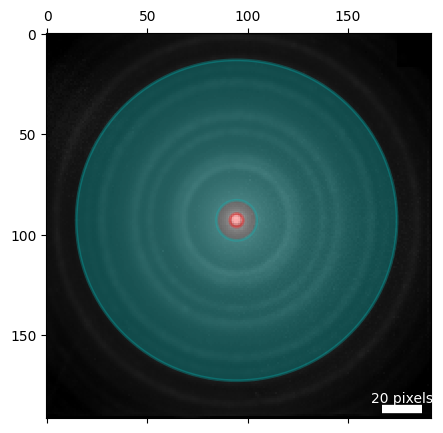

In [14]:
dataset = py4DSTEM.import_file(
    file_data,
    binfactor = bin_factor,
    scan_width = 256,
)
dataset.get_dp_mean();

dataset, mask = py4DSTEM.preprocess.filter_hot_pixels(
    dataset,
    thresh = 10 * bin_factor**2,
    return_mask = True,
    ind_compare=2,

)

dataset.get_dp_mean();
dataset.get_dp_max();

# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(
    thresh_lower=0.5,
    thresh_upper=0.6,
)

# virtual BF and DF

expand_BF = 2
radii_DF = (10 / bin_factor, 80/bin_factor)

center = (probe_qx0, probe_qy0)
radius_BF = probe_semiangle + expand_BF

# Plot the detectors
py4DSTEM.visualize.show(
    dataset.tree('dp_mean'), 
    annulus = {
        'center':center,
        'radii':radii_DF,
        'alpha':0.3,
        'fill':True,
        'color':'c',
    },
    circle = {
        'center':center,
        'R':radius_BF,
        'alpha':0.3,
        'fill':True,
        'color':'r',
    },
    vmax=1, 
    scaling='log',
)

In [15]:
pl_filepath = 'Au_From_Steph_analysis_dataset00_braggdisks_cali.h5'
model_to_use = 'unaugmented'

In [17]:
if model_to_use == 'unaugmented':
    # crystal_system_model = joblib.load('ONLY_crystal_system_model.joblib')
    crystal_system_model = joblib.load('/pscratch/sd/s/smglsn12/Structure_factors/ML_Crystal_Structure_Diffraction/Model_data/Crystal_sys_outputs/crystal_system_model.joblib')
    crystal_system_model = crystal_system_model[2]
else:
    crystal_system_model_augmented = joblib.load('ONLY_crystal_system_model_'+model_to_use+'.joblib')


In [19]:
cubic_lattice_param_model = joblib.load('ONLY_cubic_lattice_model.joblib')
hexagonal_lattice_param_model = joblib.load('ONLY_hexagonal_lattice_model.joblib')
tetragonal_lattice_param_model = joblib.load('ONLY_tetragonal_lattice_model.joblib')
trigonal_lattice_param_model = joblib.load('ONLY_trigonal_lattice_model.joblib')
monoclinic_lattice_param_model = joblib.load('ONLY_monoclinic_lattice_model.joblib')
orthorhombic_lattice_param_model = joblib.load('ONLY_orthorhombic_lattice_model.joblib')

In [20]:
pls = py4DSTEM.read(pl_filepath)

Reading PointListArray: 100%|██████████| 65536/65536 [00:07<00:00, 8605.68PointList/s]


In [21]:
lattice_dict = {
    'cubic':cubic_lattice_param_model,
    'hexagonal':hexagonal_lattice_param_model,
    'tetragonal':tetragonal_lattice_param_model,
    'trigonal':trigonal_lattice_param_model,
    'monoclinic':monoclinic_lattice_param_model,
    'orthorhombic':orthorhombic_lattice_param_model,
}

In [22]:
sum_scaling = 0.3
num_spots_needed = 5

pred_df_updated_test = predict_set_of_point_lists(pls, 
                               pl_filepath = pl_filepath,
                               cry_sys_model = crystal_system_model, 
                               sum_scaling = sum_scaling, 
                               num_spots_needed = num_spots_needed, 
                               remove_central_beam = True,
                               save_df = False,
                               save_path = '5_spots_required_sum_scaling_0_3_Au_From_Steph_analysis_dataset00_braggdisks_cali_h5_cry_sys_pred_lattice_unaugmented_model.pkl',
                               lattice_model_dict = lattice_dict,
                               cry_sys_lattice = 'all')

scaling patterns to sum intensity = 0.3 and filtering out patterns with fewer than 5 diffraction spots
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251

[Parallel(n_jobs=80)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=80)]: Done   3 out of  80 | elapsed:    0.1s remaining:    3.0s
[Parallel(n_jobs=80)]: Done  44 out of  80 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=80)]: Done  80 out of  80 | elapsed:    0.2s finished


cubic
hexagonal
tetragonal
trigonal
monoclinic
orthorhombic
finished predictions, adding confidence


In [38]:
# plt.hist(pred_df_updated.loc[pred_df_updated.prediction == 'cubic'].a_median, bins = np.linspace(2.5, 5.5, 31), label = 'cubic', fc=(1,20/255,20/255, 0.5))
# plt.hist(pred_df_updated.loc[pred_df_updated.prediction == 'hexagonal'].a_median, bins = np.linspace(2.5, 5.5, 31), label = 'hexagonal', fc=(1,191/255,0, 0.5))
# plt.hist(pred_df_updated.loc[pred_df_updated.prediction == 'tetragonal'].a_median, bins = np.linspace(2.5, 5.5, 31), label = 'tetragonal', fc=(42/255,1,48/255, 0.5))
# plt.title('Lattice params of patterns predicted cubic')
# plt.legend()

In [39]:
# plt.hist(pred_df_updated.a_median)

In [40]:
sum_scaling_str = str(sum_scaling).replace('.', '_')
pl_filepath_str = pl_filepath.replace('.', '_')
load_filepath = (str(num_spots_needed) + '_spots_required_sum_scaling_' + sum_scaling_str + '_' 
                + pl_filepath_str+'_lattice_unaugmented_model.pkl')

pred_df_updated = load_output_data(load_filepath)

In [16]:
# pred_df_updated = load_output_data('5_spots_required_sum_scaling_0_3_Au_From_Steph_analysis_dataset00_braggdisks_cali_h5_lattice_unaugmented_model.pkl')
pred_df_updated = load_output_data('5_spots_required_sum_scaling_0_3_Au_From_Steph_analysis_dataset00_braggdisks_cali_h5_cry_sys_pred_lattice_unaugmented_model.pkl')

In [17]:
pred_df_updated

,label,prediction,full_predictions,input_vector,pl_indicies,lattice_full_predictions_a,lattice_full_predictions_b,lattice_full_predictions_c,a_median,b_median,c_median,Difference_Confidence,Confidence
0,NA,hexagonal,"[tetragonal, tetragonal, cubic, cubic, monocli...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1]","[[2.82, 2.69, 2.87, 2.75, 2.47, 3.11, 3.81, 3....","[[2.82, 2.69, 2.87, 2.75, 2.47, 3.11, 3.81, 3....","[[4.56, 4.38, 5.71, 4.33, 7.8, 3.35, 3.89, 3.1...",3.02,3.02,3.64,0.0250,0.3375
1,NA,tetragonal,"[orthorhombic, cubic, tetragonal, tetragonal, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 2]","[[2.9500000000000006, 3.39, 2.88, 4.07, 4.41, ...","[[2.9500000000000006, 3.39, 2.88, 4.07, 4.41, ...","[[3.4500000000000006, 5.03, 3.87, 3.38, 2.91, ...",3.37,3.37,4.605,0.0375,0.3000
2,NA,hexagonal,"[trigonal, cubic, monoclinic, hexagonal, trigo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 3]","[[4.25, 2.89, 2.84, 2.92, 5.03, 5.47, 3.07, 2....","[[4.25, 2.89, 2.84, 2.92, 5.03, 5.47, 3.07, 2....","[[5.37, 13.1, 12.42, 10.45, 7.02, 3.02, 18.62,...",4.485,4.485,7.14,0.0500,0.3000
3,NA,tetragonal,"[trigonal, cubic, monoclinic, hexagonal, trigo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 4]","[[4.23, 10.45, 4.49, 3.57, 3.93, 3.6, 3.58, 3....","[[4.23, 10.45, 4.49, 3.57, 3.93, 3.6, 3.58, 3....","[[3.52, 5.14, 3.09, 7.51, 15.79, 6.37, 6.91, 6...",3.6,3.6,6.35,0.0125,0.2500
4,NA,hexagonal,"[cubic, hexagonal, monoclinic, cubic, cubic, h...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 5]","[[3.2000000000000006, 2.69, 3.81, 3.11, 2.47, ...","[[3.2000000000000006, 2.69, 3.81, 3.11, 2.47, ...","[[4.04, 4.38, 3.8699999999999997, 3.35, 7.8, 3...",2.965,2.965,3.84,0.0125,0.3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44595,NA,tetragonal,"[monoclinic, orthorhombic, cubic, cubic, cubic...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 249]","[[3.89, 4.24, 6.08, 4.06, 4.34, 4.83, 3.829999...","[[3.89, 4.24, 6.08, 4.06, 4.34, 4.83, 3.829999...","[[7.52, 6.760000000000001, 4.97, 10.83, 6.81, ...",4.34,4.34,7.245,0.0375,0.2500
44596,NA,tetragonal,"[hexagonal, trigonal, monoclinic, cubic, tetra...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 252]","[[2.99, 3.75, 3.03, 4.23, 4.02, 3.46, 3.32, 7....","[[2.99, 3.75, 3.03, 4.23, 4.02, 3.46, 3.32, 7....","[[3.85, 6.6, 7.4, 2.69, 5.09, 9.64, 8.18, 3.67...",3.75,3.75,6.705,0.0375,0.2750
44597,NA,cubic,"[hexagonal, cubic, tetragonal, cubic, tetragon...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 253]","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...",4.22,4.22,4.22,0.0000,0.2250
44598,NA,tetragonal,"[hexagonal, trigonal, trigonal, monoclinic, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 254]","[[3.25, 3.25, 3.03, 3.36, 4.92, 3.81, 3.27, 7....","[[3.25, 3.25, 3.03, 3.36, 4.92, 3.81, 3.27, 7....","[[2.64, 2.64, 7.4, 7.01, 2.74, 7.52, 10.77, 3....",3.36,3.36,4.91,0.1250,0.3125


100%|██████████| 65536/65536 [00:01<00:00, 44854.73it/s]


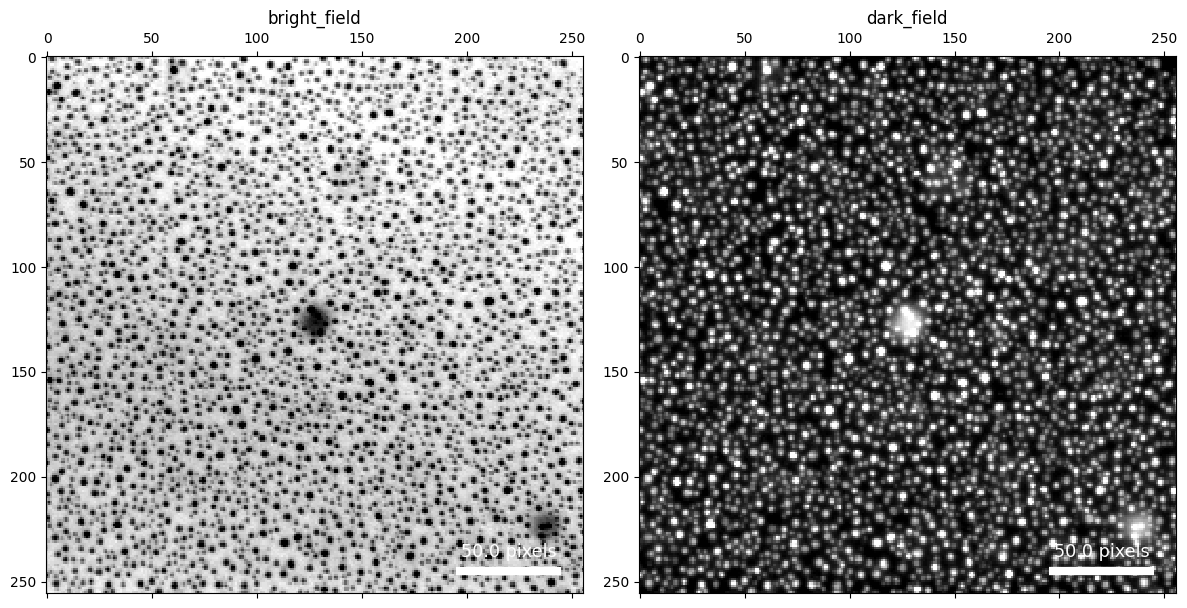

In [18]:
# Generate virtual images
dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
)
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
);

fig,ax = py4DSTEM.show(
    [
        dataset.tree('bright_field'),
        dataset.tree('dark_field'),
    ],
    figsize=(12,7),
    # bordercolor = 'w',
    cmap='gray',
    returnfig = True,
    title = [
        'bright_field',
        'dark_field',
    ],
    ticks = True,
)

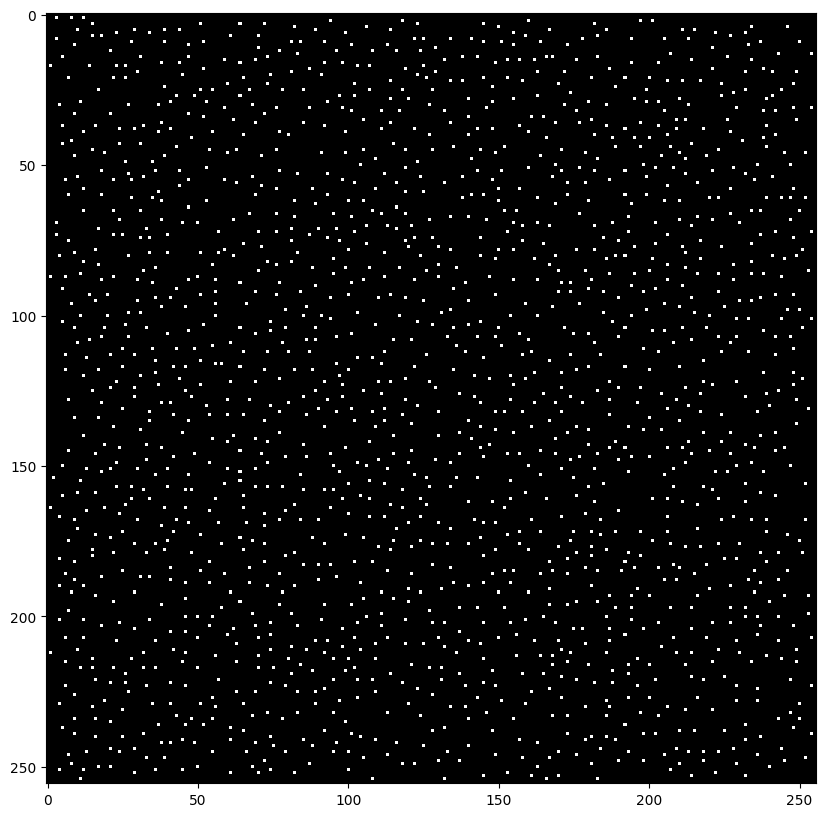

In [19]:
mask_keep = threshold_particles(
    dataset.tree('dark_field').data,
    threshold = 1e4,
    sigma = 1.0,
)
mask_keep = mask_keep.astype('int')

In [87]:
# scaled_bf = dataset.tree('bright_field').data - np.min(dataset.tree('bright_field').data)
# scaled_bf = scaled_bf/np.max(scaled_bf)
# thresholded_bf = threshold_scaled_bf_image(scaled_bf, threshold = 0.80)

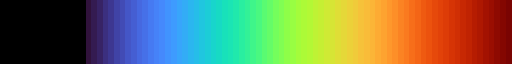

In [27]:
turbos = mpl.colormaps['turbo'].resampled(75)
newcolors = turbos(np.linspace(0, 1, 75))
white = [0,0,0,1]
newcolorlist = list(newcolors)
for i in range(0, 15):
    newcolorlist.insert(0, white)
newcolors = np.asarray(newcolorlist)
newcmp = ListedColormap(newcolors)
newcmp

In [32]:
lattice_mask = np.zeros((256, 256))
for a1 in range(3):
    temp = stack_con[a1,:,:]>0
    lattice_mask += temp.astype(int)

In [73]:
list_inds = []
for ind in inds: 
    list_inds.append(list(ind))

In [92]:
for ind in list_inds:
    if (ind in t) == False:
        print(ind)

[6, 162]
[11, 118]
[14, 111]
[14, 253]
[17, 134]
[17, 164]
[18, 40]
[18, 224]
[20, 215]
[22, 221]
[23, 231]
[30, 183]
[31, 165]
[31, 166]
[33, 214]
[33, 231]
[33, 232]
[34, 231]
[35, 252]
[36, 229]
[37, 45]
[38, 44]
[38, 45]
[38, 52]
[39, 44]
[39, 45]
[39, 114]
[39, 189]
[39, 190]
[40, 44]
[40, 113]
[40, 143]
[40, 144]
[40, 186]
[41, 44]
[43, 242]
[45, 70]
[46, 102]
[46, 176]
[46, 222]
[49, 73]
[51, 30]
[51, 33]
[51, 212]
[51, 213]
[51, 214]
[52, 30]
[54, 70]
[54, 73]
[56, 101]
[57, 9]
[57, 69]
[57, 143]
[58, 15]
[58, 98]
[58, 102]
[58, 144]
[59, 101]
[60, 72]
[63, 64]
[65, 166]
[68, 212]
[70, 22]
[70, 60]
[71, 125]
[71, 216]
[78, 37]
[79, 146]
[80, 99]
[80, 146]
[80, 205]
[81, 204]
[81, 219]
[83, 111]
[83, 112]
[84, 111]
[85, 129]
[88, 127]
[89, 26]
[91, 160]
[92, 17]
[92, 53]
[92, 160]
[93, 179]
[96, 76]
[97, 75]
[97, 76]
[97, 116]
[98, 75]
[98, 76]
[98, 114]
[100, 77]
[101, 175]
[102, 78]
[102, 79]
[104, 61]
[106, 57]
[110, 52]
[114, 141]
[115, 41]
[116, 163]
[117, 146]
[118, 114]
[

In [78]:
t = list(pred_df_updated[pred_df_updated['pl_indicies'].isin(list_inds)].pl_indicies)

In [95]:
subdf = pred_df_updated[pred_df_updated['pl_indicies'].isin(list_inds)]

In [101]:
subdf.columns

Index(['label', 'prediction', 'full_predictions', 'input_vector',
       'pl_indicies', 'lattice_full_predictions_a',
       'lattice_full_predictions_b', 'lattice_full_predictions_c', 'a_median',
       'b_median', 'c_median', 'Difference_Confidence', 'Confidence'],
      dtype='object')

In [117]:
subdf.loc[subdf.prediction == 'orthorhombic']

,label,prediction,full_predictions,input_vector,pl_indicies,lattice_full_predictions_a,lattice_full_predictions_b,lattice_full_predictions_c,a_median,b_median,c_median,Difference_Confidence,Confidence
577,NA,orthorhombic,"[hexagonal, hexagonal, orthorhombic, tetragona...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 72]","[[3.47, 3.3, 4.29, 3.96, 3.92, 3.15, 4.37, 3.4...","[[4.58, 4.59, 5.25, 7.5, 6.02, 4.29, 5.2, 4.1,...","[[5.55, 5.3, 9.12, 9.47, 8.96, 7.61, 9.3, 11.3...",3.365,4.78,7.605,0.0000,0.2750
903,NA,orthorhombic,"[orthorhombic, tetragonal, orthorhombic, hexag...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5, 42]","[[3.1, 2.9, 4.94, 2.95, 3.34, 3.73, 3.08, 3.34...","[[3.91, 2.9, 5.68, 5.09, 3.52, 6.6, 3.77, 3.52...","[[12.01, 7.8, 5.75, 5.91, 8.63, 8.82, 5.88, 8....",3.575,4.93,8.63,0.0125,0.2125
1125,NA,orthorhombic,"[cubic, orthorhombic, orthorhombic, orthorhomb...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6, 113]","[[2.83, 2.86, 3.48, 2.82, 3.71, 2.86, 4.11, 3....","[[5.77, 4.56, 3.98, 4.28, 4.62, 4.92, 4.53, 4....","[[7.86, 9.18, 9.7, 4.71, 10.84, 8.96, 5.08, 12...",3.51,4.94,8.125,0.0375,0.2250
2883,NA,orthorhombic,"[orthorhombic, orthorhombic, trigonal, hexagon...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16, 193]","[[4.6, 3.39, 3.53, 3.68, 2.92, 2.79, 2.5, 2.98...","[[7.42, 3.53, 6.98, 3.96, 2.92, 5.02, 4.33, 4....","[[7.54, 19.08, 8.31, 11.19, 8.06, 5.15, 6.9899...",3.39,4.51,7.465,0.0000,0.2000
3484,NA,orthorhombic,"[orthorhombic, monoclinic, orthorhombic, monoc...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20, 44]","[[3.17, 4.07, 4.91, 3.78, 2.9599999999999995, ...","[[7.11, 5.1, 5.42, 6.17, 4.33, 5.71, 5.78, 4.8...","[[9.39, 7.23, 6.28, 6.99, 4.9, 7.75, 6.58, 13....",3.7,5.065,7.955,0.0625,0.2875
4599,NA,orthorhombic,"[orthorhombic, hexagonal, trigonal, monoclinic...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[26, 162]","[[4.26, 5.33, 3.28, 4.68, 3.55, 4.51, 5.37, 3....","[[6.8, 5.4, 3.85, 4.98, 6.17, 5.01, 5.46, 3.28...","[[7.21, 7.57, 8.18, 5.75, 7.45, 5.75, 7.64, 8....",3.555,5.03,7.825,0.0250,0.2375
5582,NA,orthorhombic,"[cubic, tetragonal, orthorhombic, tetragonal, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[32, 52]","[[3.1, 4.14, 2.72, 4.99, 2.84, 2.86, 4.7, 3.24...","[[3.91, 4.23, 3.78, 5.46, 4.39, 4.92, 5.43, 4....","[[12.01, 15.45, 8.27, 5.8, 9.39, 8.96, 6.13, 7...",3.375,4.555,8.155,0.0125,0.2250
8018,NA,orthorhombic,"[orthorhombic, tetragonal, tetragonal, trigona...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[46, 16]","[[4.41, 4.31, 3.28, 2.77, 3.26, 4.02, 3.5, 3.6...","[[5.15, 4.78, 3.85, 4.47, 4.04, 6.86, 3.75, 4....","[[6.62, 5.33, 8.18, 4.83, 10.04, 10.46, 12.550...",3.38,4.765,8.42,0.0500,0.2750
8622,NA,orthorhombic,"[orthorhombic, hexagonal, hexagonal, monoclini...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[49, 104]","[[4.07, 3.3, 2.98, 3.41, 3.1, 2.76, 2.72, 2.92...","[[5.64, 4.59, 4.51, 4.44, 3.91, 3.59, 6.73, 4....","[[8.67, 5.3, 9.78, 5.91, 12.01, 10.01, 9.21, 9...",3.26,4.505,8.115,0.0000,0.2125
11791,NA,orthorhombic,"[trigonal, monoclinic, hexagonal, trigonal, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[67, 38]","[[3.01, 3.15, 2.78, 4.99, 2.96, 2.86, 3.79, 3....","[[5.53, 4.54, 4.57, 5.46, 4.11, 4.92, 5.9, 4.1...","[[6.37, 7.08, 4.88, 5.8, 5.48, 8.96, 6.62, 5.5...",3.37,4.4,8.44,0.0000,0.2000


In [113]:
subdf_cubic = subdf.loc[subdf.prediction == 'cubic']
subdf_hexagonal = subdf.loc[subdf.prediction == 'hexagonal']
subdf_tetragonal = subdf.loc[subdf.prediction == 'tetragonal']
subdf_trigonal = subdf.loc[subdf.prediction == 'trigonal']

In [130]:
np.linspace(2.7,14.7,61)

array([ 2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3,  4.5,  4.7,
        4.9,  5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,  6.5,  6.7,  6.9,
        7.1,  7.3,  7.5,  7.7,  7.9,  8.1,  8.3,  8.5,  8.7,  8.9,  9.1,
        9.3,  9.5,  9.7,  9.9, 10.1, 10.3, 10.5, 10.7, 10.9, 11.1, 11.3,
       11.5, 11.7, 11.9, 12.1, 12.3, 12.5, 12.7, 12.9, 13.1, 13.3, 13.5,
       13.7, 13.9, 14.1, 14.3, 14.5, 14.7])

In [140]:
medians = [np.median(subdf_cubic.a_median), np.median(subdf_hexagonal.a_median), 
      np.median(subdf_tetragonal.a_median), np.median(subdf_trigonal.a_median)]

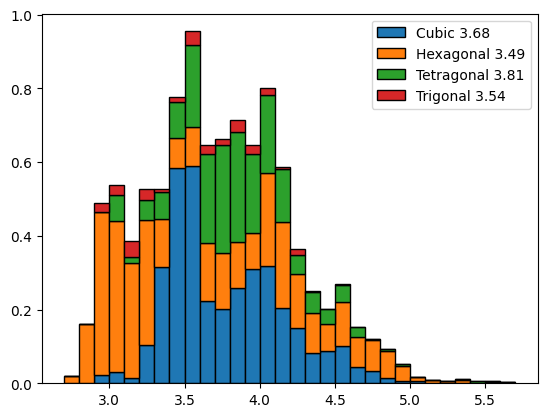

In [142]:
hist = plt.hist([subdf_cubic.a_median, subdf_hexagonal.a_median, subdf_tetragonal.a_median, subdf_trigonal.a_median], 
                edgecolor = 'k', linewidth = 1,
                bins = np.linspace(2.7,5.7,31), stacked=True, density = True)

plt.legend(['Cubic ' + str(round(medians[0], 2)), 
            'Hexagonal ' + str(round(medians[1], 2)), 
            'Tetragonal ' + str(round(medians[2], 2)), 
            'Trigonal ' + str(round(medians[3], 2))])
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Lattice_a_axis'+'.pdf', bbox_inches="tight")

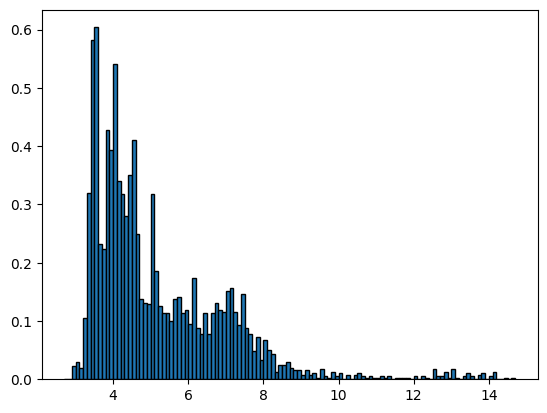

In [112]:
plt.hist(subdf.c_median, edgecolor = 'k', linewidth = 1, density = True, bins = np.linspace(2.7,14.7,121))
plt.show()

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 54., 18.,
        30.,  8., 15.,  7., 13.,  8., 22.,  6.,  9., 17., 12., 10.,  8.,
        14.,  9.,  5., 15., 15., 13., 13., 14., 43., 23., 20., 28., 18.,
        26., 35., 24., 28., 45., 26., 32., 27., 36., 22., 18., 12.,  9.,
         2., 12.,  6.,  5.,  2.,  6.,  6.,  2.,  1.,  1.,  0.,  1.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([ 2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,
         3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,
         4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,
         6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,
         7.1,  7.2,  7

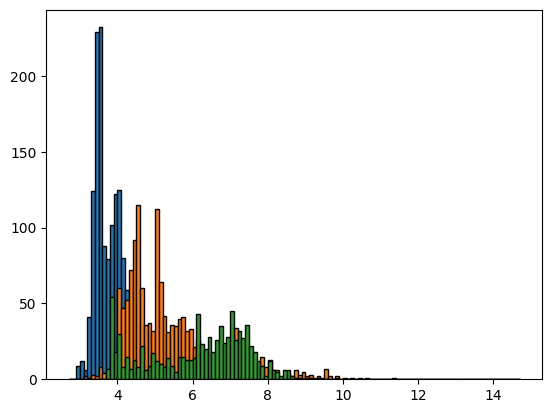

In [106]:
plt.hist(subdf_cubic.c_median, edgecolor = 'k', linewidth = 1, density = False, bins = np.linspace(2.7,14.7,121))
plt.hist(subdf_hexagonal.c_median, edgecolor = 'k', linewidth = 1, density = False, bins = np.linspace(2.7,14.7,121))
plt.hist(subdf_tetragonal.c_median, edgecolor = 'k', linewidth = 1, density = False, bins = np.linspace(2.7,14.7,121))

In [94]:
pred_df_updated[pred_df_updated['pl_indicies'].isin([[162,6]])]

,label,prediction,full_predictions,input_vector,pl_indicies,lattice_full_predictions_a,lattice_full_predictions_b,lattice_full_predictions_c,a_median,b_median,c_median,Difference_Confidence,Confidence


In [57]:
inds = np.argwhere(lattice_mask > 0)

In [64]:
inds[0]

array([  1, 137])

In [21]:
lattice_a = np.asarray(pred_df_updated.c_median)

5.389751008968585

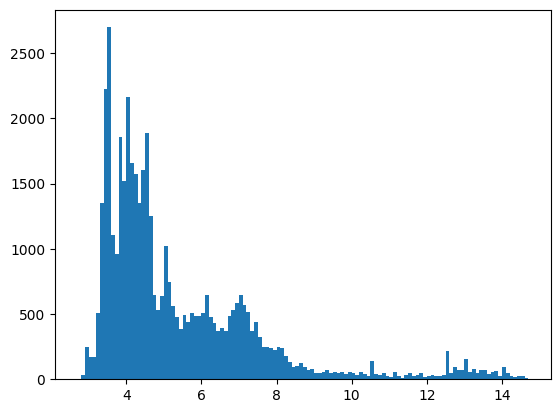

In [29]:
plt.hist(lattice_c, density = False, bins = np.linspace(2.7,14.7,121))
np.mean(lattice_c)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.5281663516068068, 0.34319470699432847, 0.1286389413988647]


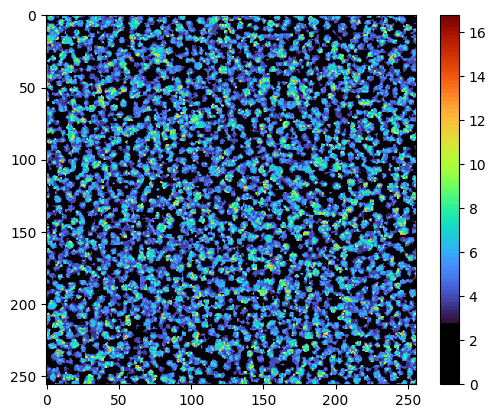

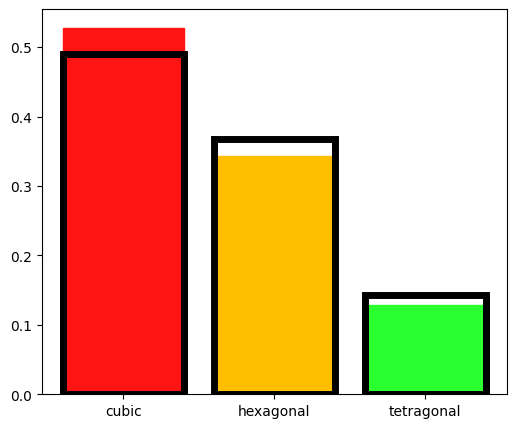

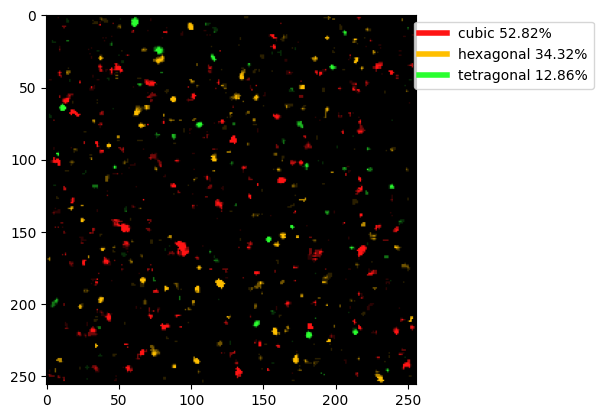

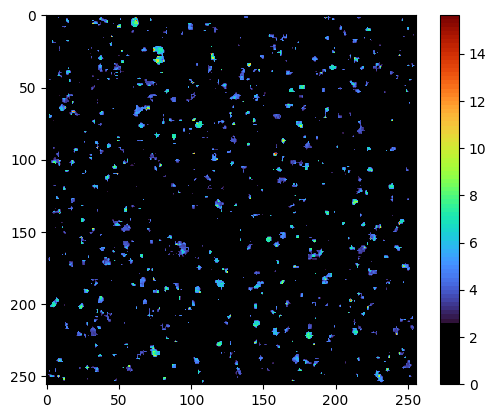

4.56
5.174992450931051


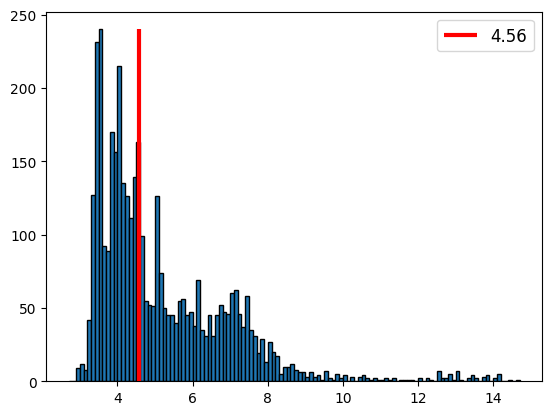

['cubic', 'hexagonal', 'tetragonal']
['cubic', 'hexagonal', 'tetragonal']


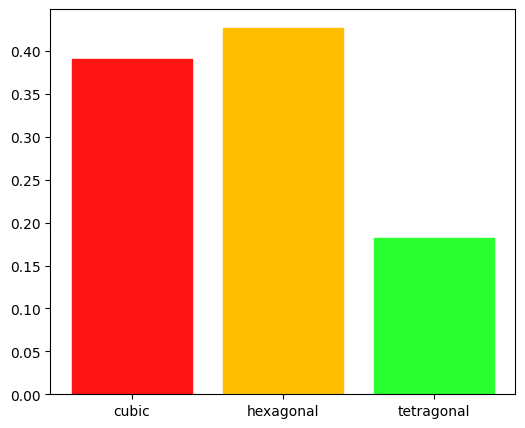

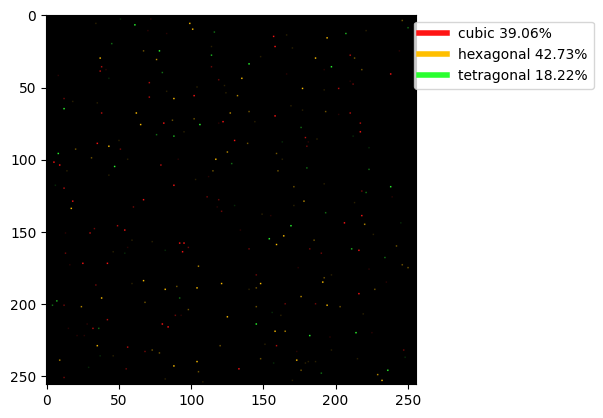

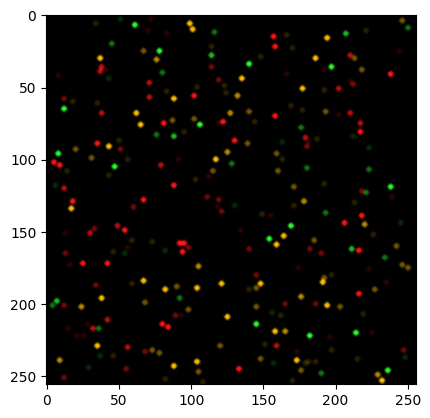

In [28]:
for legend_type in ['Diff Con Percents']:

    pred_image, stack_con = confidence_image(
            pred_df_updated,
            im_shape = (256, 256),
            plot_result = True,
            cry_sys = [
                'cubic',
                'hexagonal',
                'tetragonal',
                # 'trigonal',
                # 'orthorhombic',
                # 'monoclinic',
            ], 
            mask_threshold=mask_keep,
            threshold_image = True,
            mask_range = (0.005,0.05),
            medfilt_shape = (5,5),
            legend_type = legend_type,
            save_figure = False,
            figure_path = 'lattice_using_predicted_models_c',
            # mask_range = (0.05,0.2),
            lattice_color_map = newcmp,
            

        )

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[69.8500000000005, 45.38750000000014, 17.01249999999993]


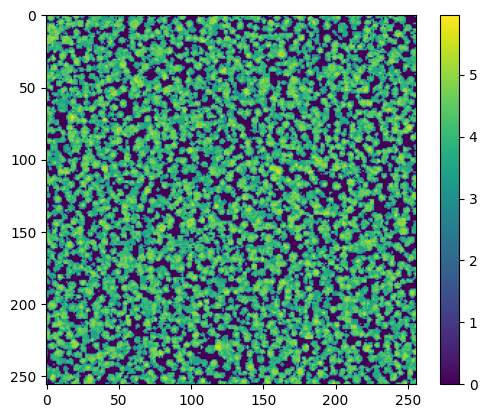

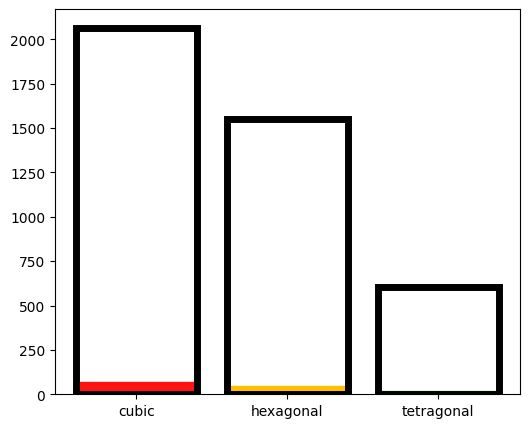

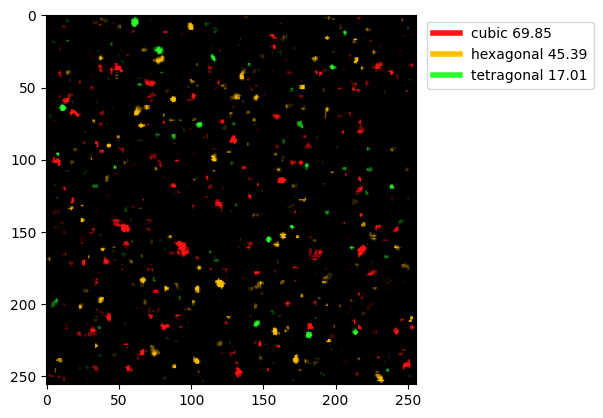

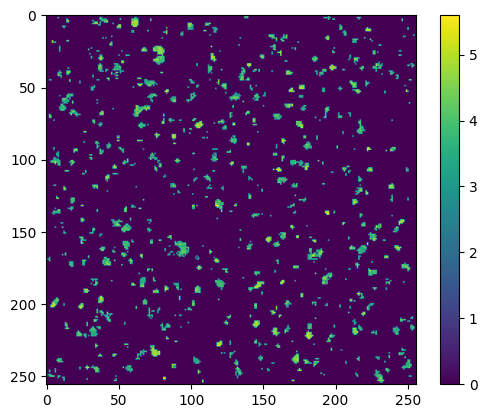

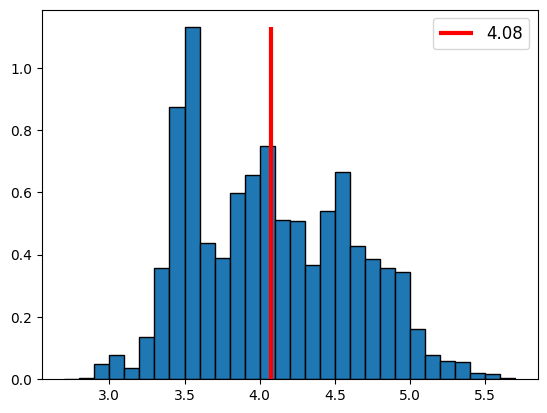

['cubic', 'hexagonal', 'tetragonal']
['cubic', 'hexagonal', 'tetragonal']


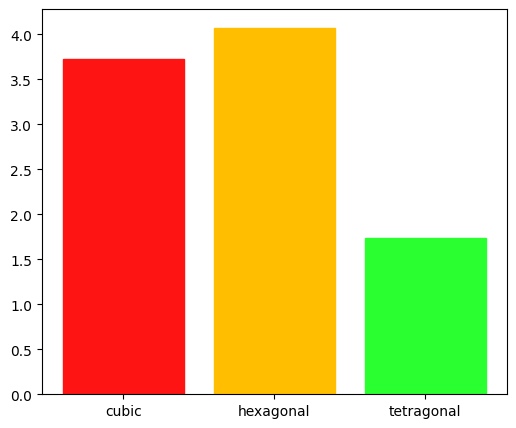

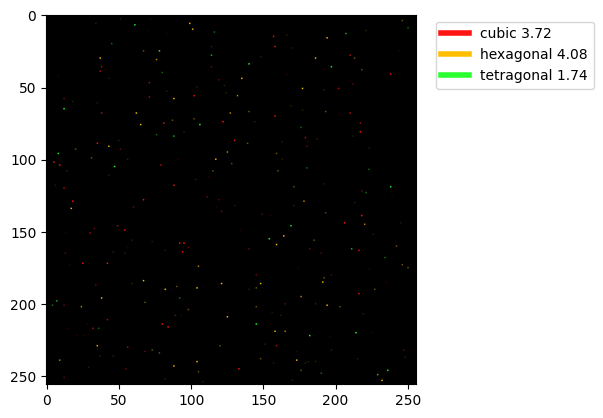

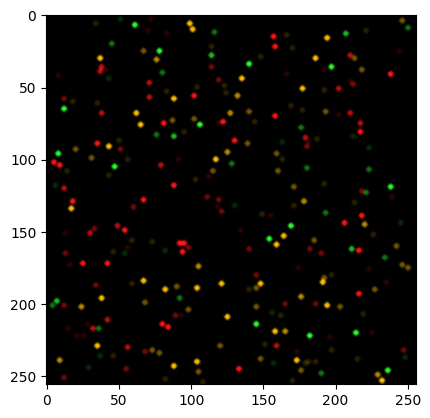

In [121]:
# for legend_type in ['Percent Counts', 'Diff Con', 'Diff Con Percents']:
for legend_type in ['Diff Con']:

    pred_image, stack_con = confidence_image(
            pred_df_updated,
            im_shape = (256, 256),
            plot_result = True,
            cry_sys = [
                'cubic',
                'hexagonal',
                'tetragonal',
                # 'trigonal',
                # 'orthorhombic',
                # 'monoclinic',
            ], 
            mask_threshold=mask_keep,
            threshold_image = True,
            mask_range = (0.005,0.05),
            medfilt_shape = (5,5),
            legend_type = legend_type,
            save_figure = True,
            figure_path = '5_spots_required_unaugmented_model_medfilt_5x5_mask_range_005_05',
            # mask_range = (0.05,0.2),

        )

In [88]:
stack_con[1, 28:33,75:80]

array([[0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.025 , 0.    , 0.    , 0.0625, 0.0625],
       [0.0875, 0.0125, 0.025 , 0.2125, 0.075 ],
       [0.    , 0.0375, 0.075 , 0.0625, 0.0875],
       [0.0875, 0.0625, 0.    , 0.025 , 0.1375]])

In [94]:
inds = np.argwhere(stack_con[0,:,:] > 0)

In [116]:
temp[0].savefig('test')

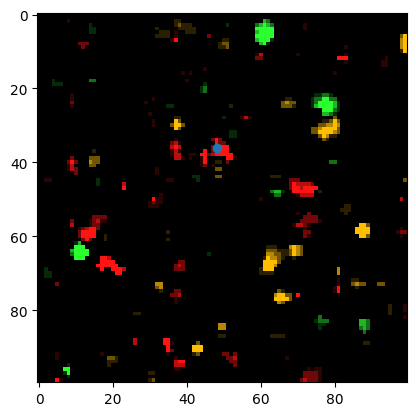

In [92]:
plt.scatter(48,36)
plt.imshow(pred_image[:100:,:100])

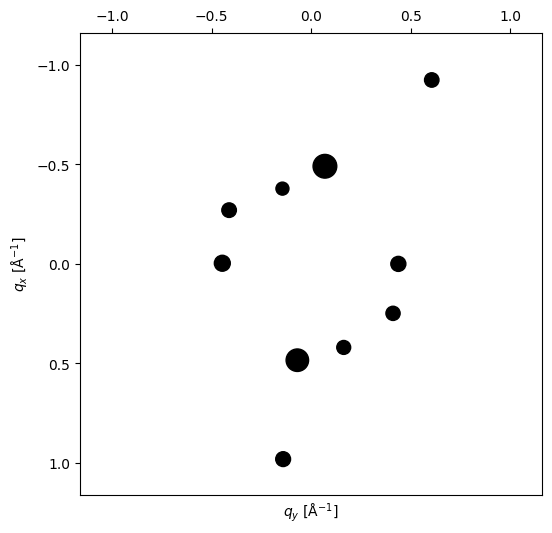

In [118]:
fig = visualize_specific_pattern(
    pls, 
    index = (36,48) ,
    intensity_scaling = 1,
    )
plt.rcParams['pdf.fonttype'] = 'truetype'
fig.savefig('cubic_pattern.pdf', bbox_inches="tight")


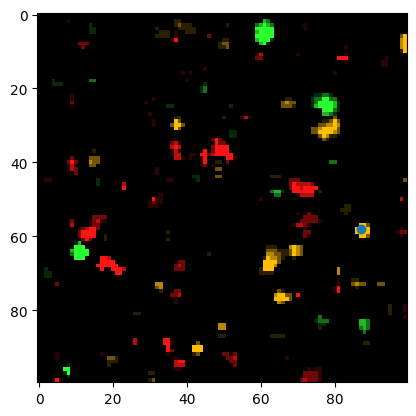

In [94]:
plt.scatter(87,58)
plt.imshow(pred_image[:100:,:100])

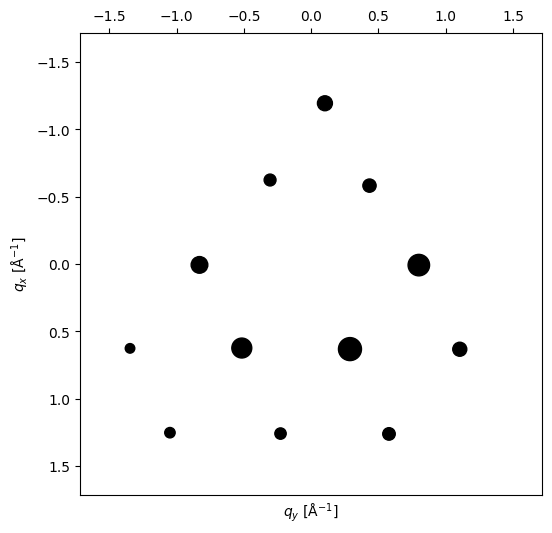

In [119]:
fig = visualize_specific_pattern(
        pls, 
        index = (58,87) ,
        intensity_scaling = 1,
        )
plt.rcParams['pdf.fonttype'] = 'truetype'
fig.savefig('hexagonal_pattern.pdf', bbox_inches="tight")

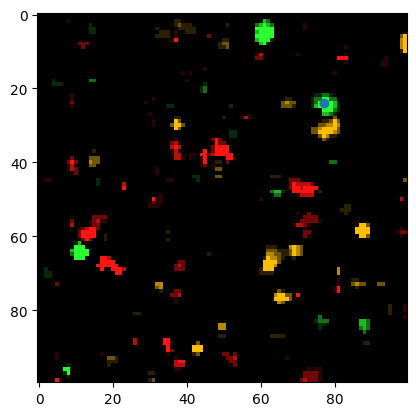

In [96]:
plt.scatter(77,24)
plt.imshow(pred_image[:100:,:100])

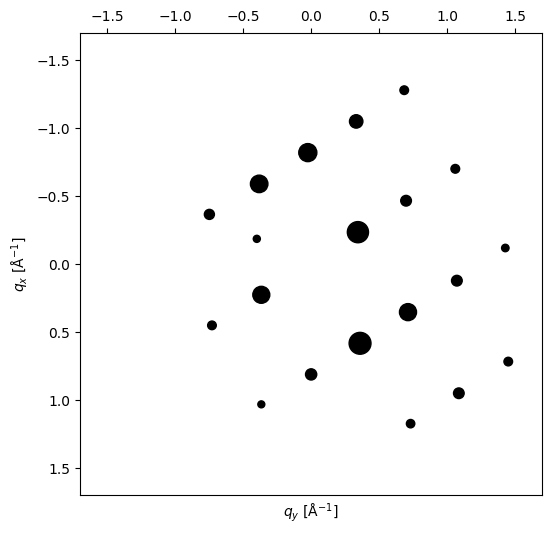

In [120]:
fig = visualize_specific_pattern(
        pls, 
        index = (24,77) ,
        intensity_scaling = 1,
        )
plt.rcParams['pdf.fonttype'] = 'truetype'
fig.savefig('tetragonal_pattern.pdf', bbox_inches="tight")

In [104]:
np.max(stack_con[0])

0.7124999999999999

In [159]:
np.max(pred_image[:,:,0])

1.0

In [26]:
0.187363/(0.187363+0.302043+0.372961)

0.21726596680995447

(array([ 2.,  0., 39.,  0.,  4.,  0., 15.,  0., 18.,  2.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

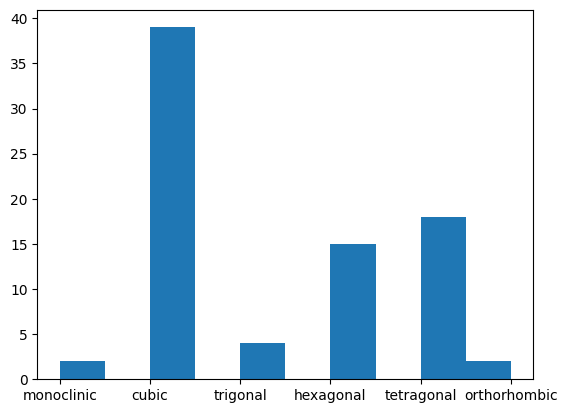

In [7]:
plt.hist(pred_df_updated.iloc[7].full_predictions)

cubic           0.368161
hexagonal       0.314888
tetragonal      0.221121
trigonal        0.078498
orthorhombic    0.017175
monoclinic      0.000157
Name: prediction, dtype: float64


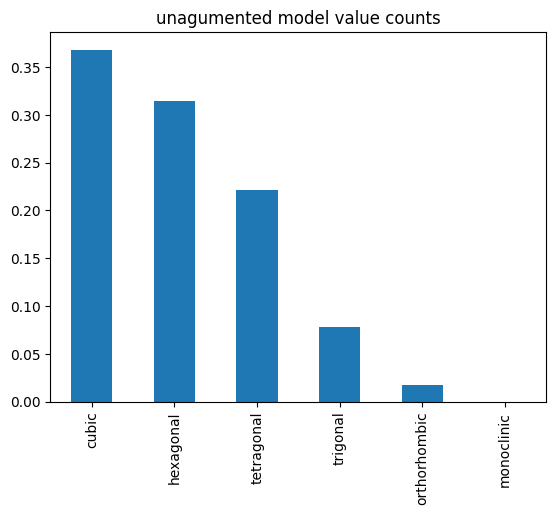

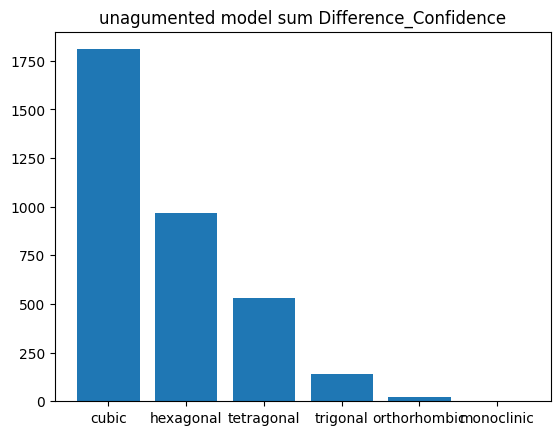

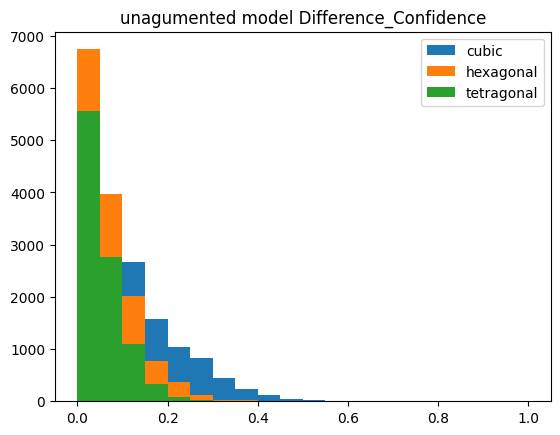

In [66]:
visualize_output(pred_df_updated, 'unagumented', 'Difference_Confidence')

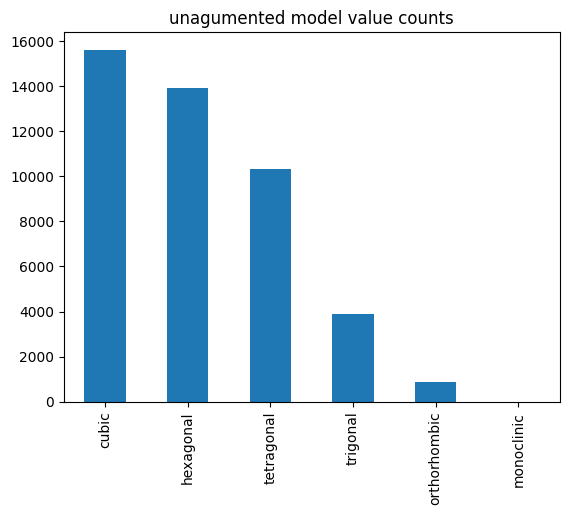

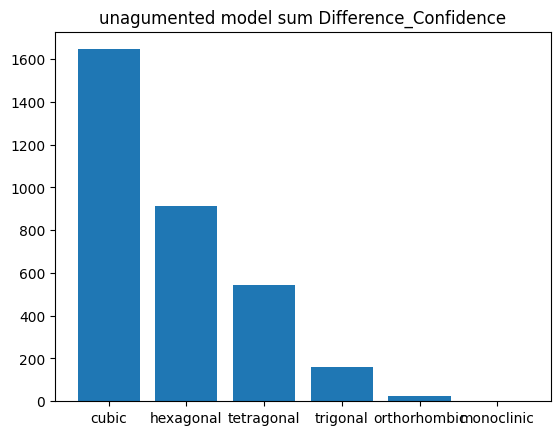

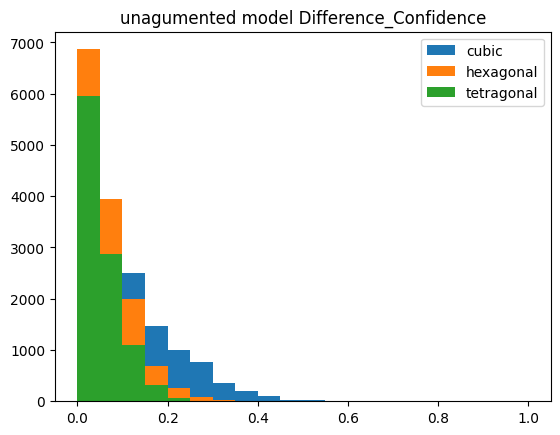

In [20]:
visualize_output(pred_df_updated, 'unagumented', 'Difference_Confidence')

In [10]:
def pixel_wise_real_space_distribution(df):
    grid = np.zeros((256,256))
    for i in range(0, len(df)):
        row = df.iloc[i]
        indicies = row.pl_indicies 
        if row.prediction == df.prediction.value_counts().index[0]:
            grid[indicies[0], indicies[1]] = 1.0
        if row.prediction == df.prediction.value_counts().index[1]:
            grid[indicies[0], indicies[1]] = 0.67
        if row.prediction == df.prediction.value_counts().index[2]:
            grid[indicies[0], indicies[1]] = 0.33
            
    plt.imshow(grid)
    plt.colorbar()
    return grid 

In [11]:
grid = pixel_wise_real_space_distribution(pred_df_updated)

KeyboardInterrupt: 

In [ ]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = (mpl.colors.ListedColormap(['k', 'yellow', 'red', 'cyan'])
        .with_extremes(under='yellow', over='magenta'))
bounds = [-0.3, 0.01, 0.331, 0.671, 1.01]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax, orientation='horizontal',
    extend='both',
    spacing='proportional',
    label='Discrete intervals, some other units',
)

In [ ]:
plt.figure(figsize = (12,12))
plt.imshow(grid, cmap = cmap)
plt.colorbar()

In [81]:
def visualize_real_space_distribution(df):
    for cry_sys in ['cubic', 'trigonal', 'tetragonal','hexagonal', 'monoclinic', 'orthorhombic']:
        xs = []
        ys = []
        coords = np.asarray(df.loc[df.prediction == cry_sys].pl_indicies)
        for cord in coords:
            xs.append(cord[1])
            ys.append(cord[0])
        if cry_sys == 'cubic':
            plt.scatter(xs,ys, s=1, label = cry_sys, zorder=10)
        else:
            plt.scatter(xs,ys, s=1, label = cry_sys)

    plt.gca().invert_yaxis()
    plt.legend(bbox_to_anchor=(1.03, 1.05))

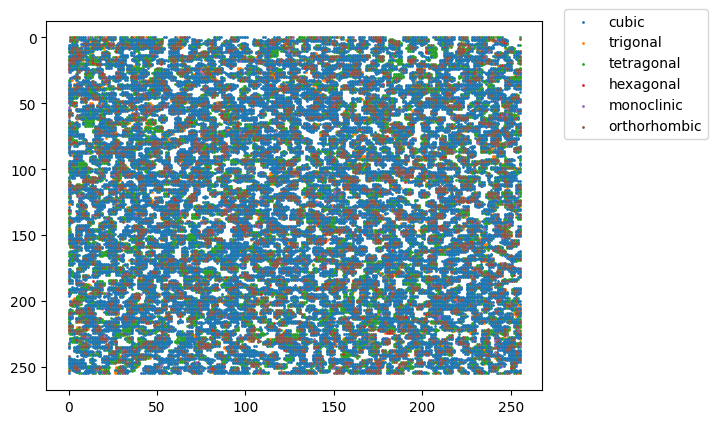

In [9]:
visualize_real_space_distribution(pred_df_updated)

(array([20.,  0., 11.,  0.,  6.,  0., 13.,  0., 21.,  9.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

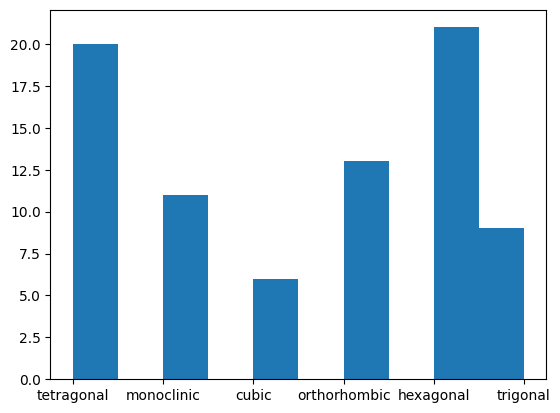

In [21]:
plt.hist(pred_df.full_predictions.to_numpy())

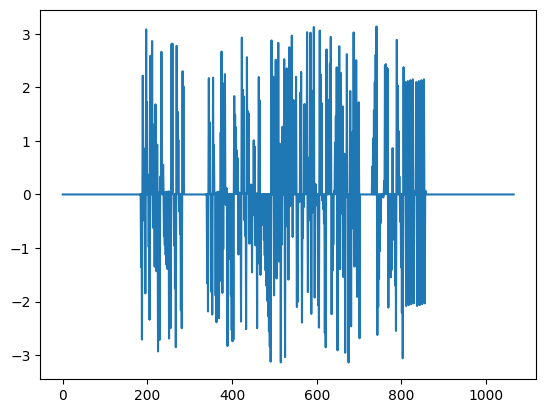

In [22]:
plt.plot(input_test[0])

(array([ 8.,  0., 18.,  0., 16.,  0., 16.,  0., 15.,  7.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

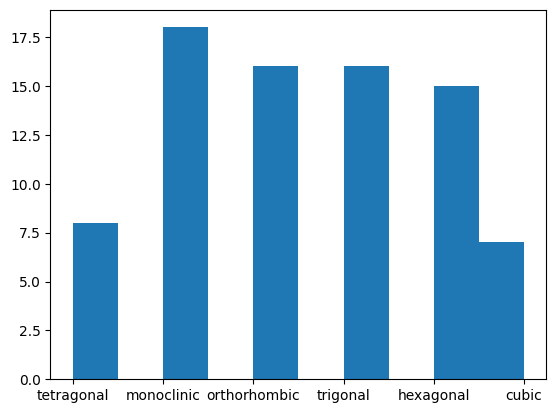

In [58]:
plt.hist(pred_df.full_predictions)

<Axes: >

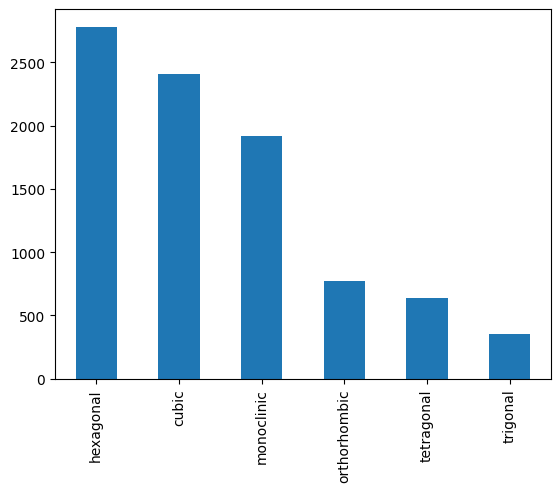

In [163]:
pred_df['prediction'].value_counts().plot(kind='bar')

In [165]:
sum(pred_df.iloc[4928].model_input) # 0.01 scaling 

-98.72198784911308

In [166]:
# with open('reference_predictions_AuAgPd.pkl', 'rb') as f:
#     pred_df_full = pickle.load(f)

In [167]:
# sum(pred_df_full.iloc[4928].model_input) # no scaling from earlier today

3825.1115175136083

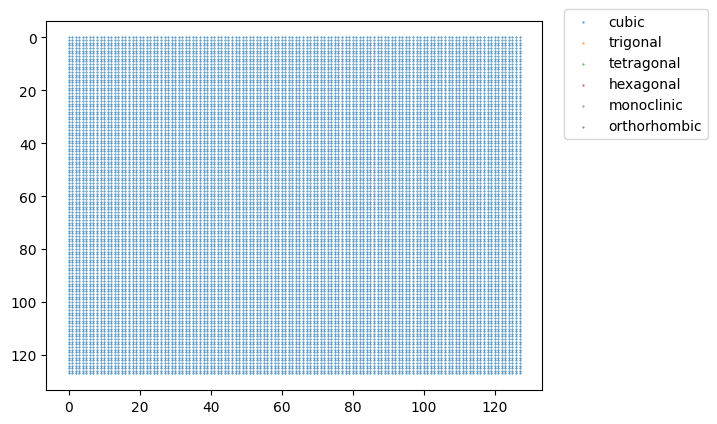

In [82]:
# sum intensity = 0.01
for cry_sys in ['cubic', 'trigonal', 'tetragonal','hexagonal', 'monoclinic', 'orthorhombic']:
    xs = []
    ys = []
    coords = np.asarray(pred_df.loc[pred_df.prediction == cry_sys].pl_indicies)
    for cord in coords:
        xs.append(cord[1])
        ys.append(cord[0])
    plt.scatter(xs,ys, s=0.2, label = cry_sys)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.03, 1.05))

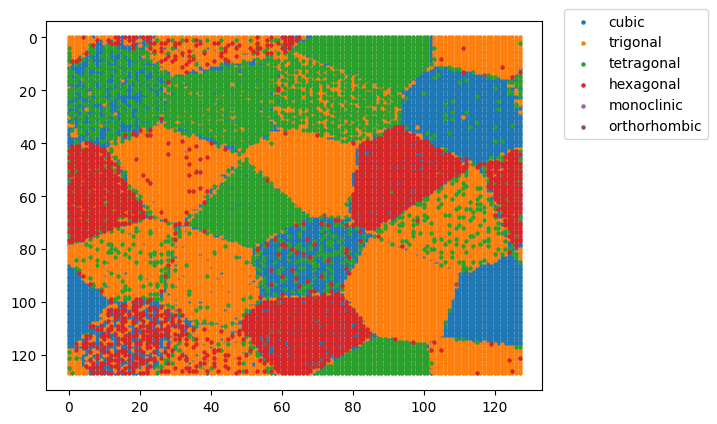

In [76]:
# sum intensity = 0.75
for cry_sys in ['cubic', 'trigonal', 'tetragonal','hexagonal', 'monoclinic', 'orthorhombic']:
    xs = []
    ys = []
    coords = np.asarray(pred_df.loc[pred_df.prediction == cry_sys].pl_indicies)
    for cord in coords:
        xs.append(cord[1])
        ys.append(cord[0])
    plt.scatter(xs,ys, s=5, label = cry_sys)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.03, 1.05))

In [88]:
with open('reference_predictions_AuAgPd.pkl', 'rb') as f:
    pred_df_full = pickle.load(f)

(array([16.,  0., 47.,  0.,  0.,  6.,  0., 10.,  0.,  1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

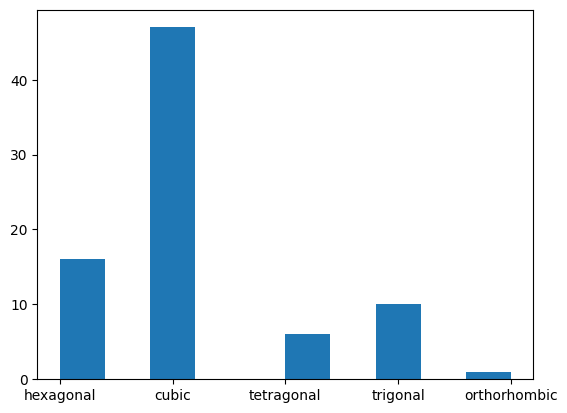

In [100]:
plt.hist(pred_df_full.iloc[400].full_predictions)

(array([34.,  0., 13.,  0.,  0., 16.,  0., 14.,  0.,  3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

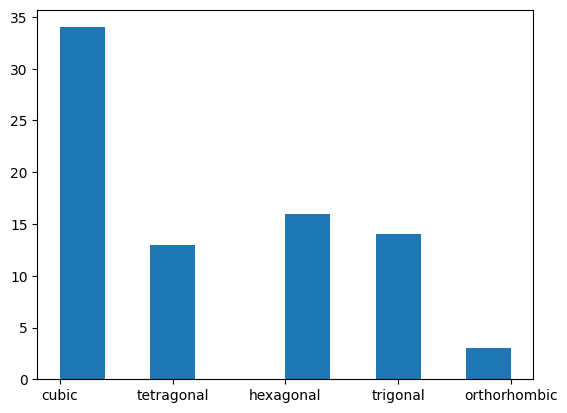

In [97]:
plt.hist(pred_df.iloc[0].full_predictions)

(array([20.,  0., 18.,  0., 13.,  0., 19.,  0.,  1.,  9.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

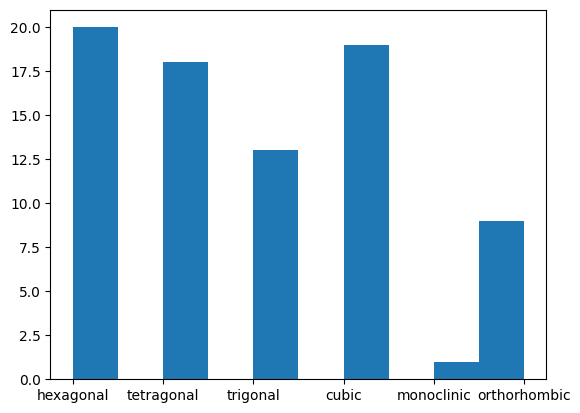

In [65]:
plt.hist(pred_df_full.iloc[8729].full_predictions)

(array([20.,  0., 18.,  0., 13.,  0., 19.,  0.,  1.,  9.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

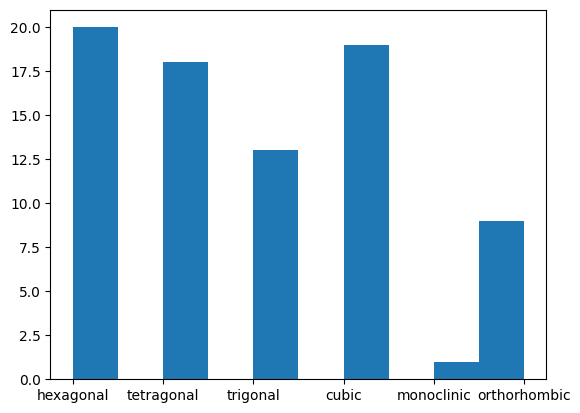

In [66]:
plt.hist(pred_df.iloc[0].full_predictions)

In [78]:
pred_df.to_pickle('reference_predictions_ws2.pkl')

<Axes: >

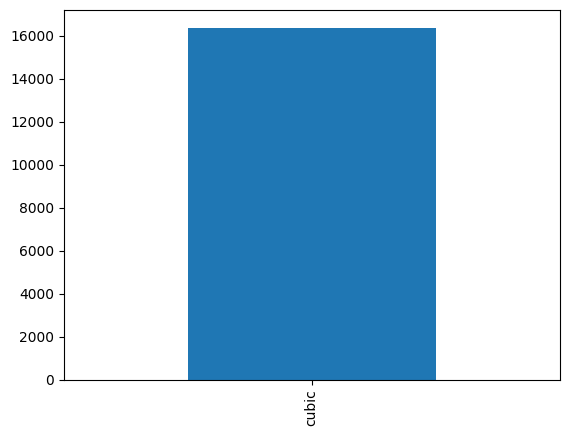

In [79]:
pred_df['prediction'].value_counts().plot(kind='bar')

cubic           42
tetragonal      18
trigonal         7
hexagonal        6
orthorhombic     5
monoclinic       2
dtype: int64


Text(0, 0.5, 'num trees')

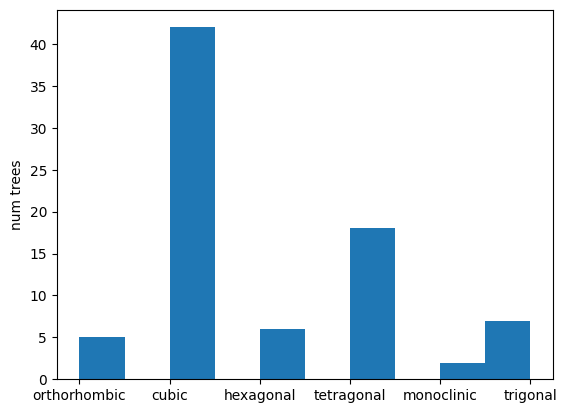

In [82]:
plt.hist(pred_df.iloc[0]['full_predictions'])
print(pd.DataFrame(pred_df.iloc[0]['full_predictions']).value_counts())
plt.ylabel('num trees')

cubic           71
orthorhombic     4
monoclinic       2
tetragonal       2
trigonal         1
dtype: int64


Text(0, 0.5, 'num trees')

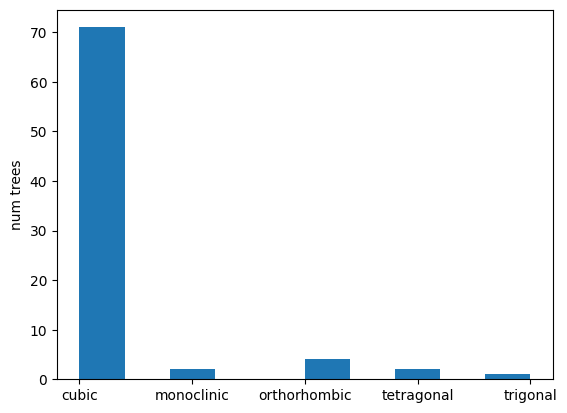

In [86]:
# reference for simulated pattern 
plt.hist(pred_df.iloc[0]['full_predictions'])
print(pd.DataFrame(pred_df.iloc[0]['full_predictions']).value_counts())
plt.ylabel('num trees')